## Introduction
## Simulation of th Palu region Tsunami
The following code simulates the Indonesia Palu area Tsunami.  To do this the following steps are required
* Define the simulation code
* Open Bathymetry database and extract the ocean depth and land heights for the region of interest near palu
* Set up parameters for finite element grid
* Create Disk Memory Map to Virtual memory to allow processing of arrays larger than RAM memory during animation 
* Iterate differential equations, and periodically generate animation frames
Additionally prior to executing various unit test verifications are run
* Define code for unit test on simple 1-D and 2D problems with well known results
* validate assertions that simulation is correct.
* Simulate Palu event and other hypothetical events over time
* plot animations and maximum height distributions of Tsunami for various initial conditions.


## User Interface
### This is not just an annotated program listing but an interactive notebook
This is Jupyter Notebook intereactive environment.  Like a Matalb or Mathematica Notebook, code is divided into input cells, and if there is output from a cell it is displayed below it.  The entrire notebook can be run from start to finish like a traditional program or onne can interactively edit cells (to change parameters or logic) then re-execute cells out of order.  
### Coding styles for massively parallel computation
In the code you will see a mixture of different styles of code idioms that suited for different kinds of computing.  In places the same basic function is re-implemented several ways since it's easier to include debugging, validation code, and __avoid global variables__  in the less restrictive slower syntaxes.
* <b>"pure" Python.  </b>
<br>Strictly scalar effectively single threaded but allows rich object types
* <b>Numpy (typically ~20x faster)</b>
<br>Rich Matrix Operations. "Matlab" copycat syntax, allows operator level multi-processing and SIMD.
* <b>Numba (Can be 100x faster)</b>
<br>Fuses arbitrary scalar code and compiles "pure" python into kernels.  These become fast complex matrix operations for Numpy.  Restricited syntax and no rich object types. 
* <b>Cuda (can be  1000x faster)</b>
<br>massively threaded SIMT streaming processors on GPU.  Millions of threads running on thousands of cores. Very constrained syntax, strong resource constraints.  Benefit occurs when code can thread easily. 
#### Massively parallel GPU Tsunami simulation 28 X faster than real time on large ocean grids.
Benchmarking algorithms that depend strongly and non-linearlry on the size and "parallel-ness" of the problem doesn't provide a simple picture. Taking a practical case:  On a 50 meter resolution grid, covering 80,000KM^2, the GPU simulation ran 28x real time. For the eight million point grid, my massively parallel (~25,000 threads on thousands of cores) GPU code was 66 times faster than the CPU code running SIMD and fully parallel, after compilation by Numba. The Numpy was 40% real time. The Numpy code was about 4% real time.  It was too long to make comparable measurements at the same scale in the pure python, as it would have taken a week.  At smaller scales, where the python code can be benched, the  GPU is actually slower than the Numpy code and so can't be compared.<br>
   <b> My test hardware is my personal computer:</b>
- <b>CPU:</b> i7-9700K CPU @ 3.60GHz 16GB, 8 core  128bit SIMD per core
- <b>GPU:</b> Nvidia RTX 2070 GPU @ 1.4GHz 8GB (~2500 cores,  ~32000 threads)

Faster than real-time is useful not just for convenience and cost but also because when seismic events occur in unexpected locations the hazard zones can be forecasted before the wave arrives.



# import libraries
libraries for math, plotting, user interface, database connnection, GPU connection,  and compiling.

In [1]:
%matplotlib notebook

# %env
# %env NUMBA_ENABLE_CUDASIM=1
import numpy as np
import numba as nb
from numba import cuda
import operator as op
import time
import matplotlib as mpl
import pandas as pd
from pandas import HDFStore, DataFrame
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc
from math import sqrt
mysqrt= sqrt # numba replacement for np.sqrt


# Reader Tutorial: 
## Examples of the four coding styles from single threaded scalars to massiviely parallel vectors.
So the reader can recognize these in the main code, and not get confused, here's a trivial  example for a scalar times a vector implemented in the four numerical approaches described above.
 

In [2]:
# just some setup for this demo tutorial

N=1000 # parameter to set size
X = np.ones(N,dtype=np.float32) # make a vector of ones, size N, of 4 byte floats
Out = np.empty(N,dtype=np.float32) # allocate space to put result
a = 2

In [3]:
# numpy vector style (very compact notation for linear algebra)

Out[:] = a*X

#%timeit Out[:]=a*X

In [4]:
# Pure python style with explicit loops

def pyScale(a,X,Out): 
    dot = 0.0
    for i in nb.prange(X.size):
        Out[i]=X[i]*a

#%timeit pyScale(a,X,Out)
    

In [60]:
# numba style to compile python into a parallel CPU kernel

numbaScale = nb.njit(pyScale,fastmath=True,parallel=True)

# execute it
numbaScale(a,X,Out)

#%timeit numbaScale(a,X,Out)

NameError: name 'X' is not defined

Lastly, the Cuda code for the GPU.  
This requires a lot of set up to define the memory management on the GPU and how the threads will be divided up on the
processors on the GPU. The final function that results is called like other python functions but uses the GPU memory.  The kinds of calculations one can do on a GPU are more limited than python.  So one uses these functions for speed inside python.

In [6]:
#Cuda GPU style.  
# Limited to on-device memory and only useful for SIMT vector ops.

# move arrays to dedicated GPU memory
d_X = nb.cuda.to_device(X)
d_Out = nb.cuda.to_device(Out)

# kernel for a single thread
def pykernel_scale(a,X,Out):
    i = cuda.grid(1) # thread index
    if i<X.shape[0]:
        Out[i]=a*X[i]

# compile the python kernel to GPU code
cuda_scale_kernel = nb.cuda.jit(pykernel_scale)

# set up array of streaming multiprocessor threads precisely tuned to array size
blockDim = 256  # number of threads per streaming multi-processor
gridDim = (X.shape[0]+blockDim-1)//blockDim  # number of thread blocks

# Assign streaming multiprocessors and threads
cuda_scale = cuda_scale_kernel[gridDim,blockDim]

# this schedules blockDim (<1024) simultaneous threads on up to gridDim streaming processors each with 2048 cores.
# thus can have tens of thousands threads on thouands of cores in flight for large arrays

# execute it
cuda_scale(a,d_X,d_Out)

#%timeit cuda_scale(a,d_X,d_Out)

In [62]:
# cleanup and release GPU and CPU memory from tutorial
del d_X
del d_Out
del X
del Out

NameError: name 'd_X' is not defined

# Define some frequently used constants
Because python defaults to 8 byte ints and floats, whereas GPU memory busses and CPU SIMD are optimized for 4 byte ints and floats, it's useful to pre-cast some often used constants.

In [8]:
# common constants: pre-cast to float32 form to speed up calculations.  
#    convenient to make globals
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

# utility function: First order derivaties for 2D matricies
Derivative is formed by taking difference of adjacent values along one axis, and dividing by delta.

<b>Note while one could define higher order derivative calculations using additional next-nearest neighbors this not useful here.</b> In the later code we will be averaging these derivates making them effectively higher order central differences, and the Rutte Kunga style integrators in use will further average these over time steps making these effectively fourth or fifth order in the results even though we begin with simple first differences.

This is also the first example of using a combination of both Numpy vector ops, and Numba just-in-time run-time compilation.


In [9]:
# First order differential functions

# derivative in x
@nb.njit(fastmath=True,parallel=True)
def d_dx(a, dx):
    return ( a[1:] - a[:-1] )*(np.float32(1)/dx) # ddx

# derivative in y
@nb.njit(fastmath=True,parallel=True)
def d_dy(a, dy):
    return ( a[:,1:] - a[:,:-1] )*(np.float32(1)/dy)


# Tsumani Wave type examples.
This code will be using two different wave shapes for simulation of tsunamis. 
* A simple uplift using a truncated, possibly eliptical, Gaussian
* A "Seismic" shape that is sutied to a slip-fault and other types of waves.

Here are some static images of these common wave models taken from the literature (see References)

Figure 1: simple 2d disturbance
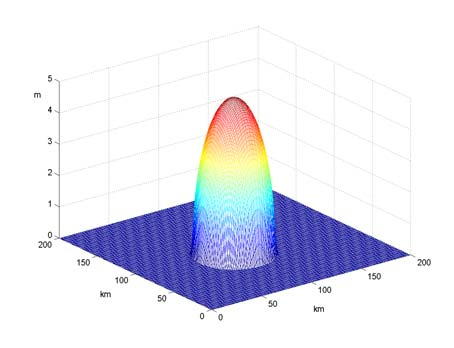

Figure 2: "seismic" disturbance, with negative and positive height deviation
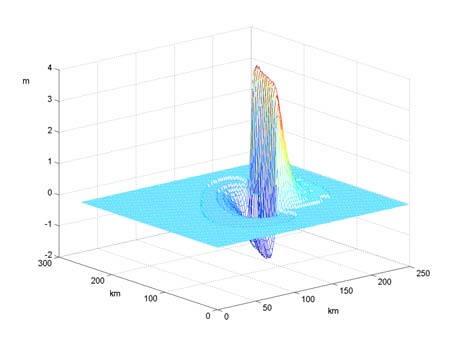

In [10]:
# simple environments or initial conditions

# create a simple 1d gaussian disturbance
def lingauss(shape, w, cx = 0, cy = 0, theta = 0, cutoff = 0.05, norm = False):#, win = (-2, 2)):
    """returns a 1d gaussian on a 2d array of shape 'shape'"""
    x = np.arange(0, shape[0])#linspace( win[0], win[1], shape[0] )
    y = np.arange(0, shape[1])#linspace( win[0], win[1], shape[1] )
    xx, yy = np.meshgrid(x, y, indexing='ij')
    xy = np.cos(theta)*(xx-cx) + np.sin(theta)*(yy-cy) # lin comb of x, y, to rotate gaussian
    h = np.exp( - ( xy*xy ) / (2*w*w) )
    if norm:
        h = h / (np.sqrt(two*np.pi)*w)
    h -= cutoff
    h[np.less(h, zero)] = zero
    return (h)

# creates a simple 2d disturbance (see figure 1)
def planegauss(shape, wx, wy, cx=0, cy=0, theta = 0, cutoff = 0.05, norm = False):
    h1 = lingauss(shape, wx, cx=cx, cy=cy, theta = theta, cutoff=cutoff, norm=norm)
    h2 = lingauss(shape, wy, cx=cx, cy=cy, theta = theta + np.pi/2, cutoff=cutoff, norm=norm)
    return h1*h2

# creates a "seismic" distrubance, with negative and positive height deviation (see figure 2)
def seismic(shape, width, length, cx=0, cy=0, theta=0, a1 = 1, a2 = 1, cutoff=0.05, norm=False):
    """returns simple seismic initial condition on array with shape 'shape'
        theta - angle of rotation
        length - length across distrubance
        width - width across disturbance
        a1 - amplitude of positive portion of distrubance
        a2 - amplitude of negative portion of disturbance
        cx - the x position of the distrubance
        cy - the y position of the disturbance
        cutoff - the magnitude below which values are rounded to zero"""
    offx = width*np.cos(theta)*0.5
    offy = width*np.sin(theta)*0.5
    h1 = a1*planegauss(shape, width, length, cx=cx+offx, cy=cy+offy, theta = theta, cutoff=cutoff, norm=norm) # 'hill'
    h2 = -a2*planegauss(shape, width, length, cx=cx-offx, cy=cy-offy, theta = theta, cutoff=cutoff, norm=norm) # 'valley'
    return h1+h2

##  Setup simulation
The simulation requires specifying the location on earth, the size of the simulation region. The resolution in space is set.  This detemines the maximum time step via the CDL condition relating grid size and wave speed.
### Adjustable paramters
This model has only two ajustable physics parameters and the results are not sensitive to these. One is the friction coefficient, and the other is the depth defining where the coastal land starts.

These are not set by fitting them to data but simply set to practical values. The friction damps instabilities so it is set to the lowest value where the time steppers are stable.  The coastal edge is set 1 to 15 meters off shore ahead of the surf zone where the Shallow Water equations don't apply.  The bigger the Tsunami wave the further out the surf zone is set.  This is not important to the maximum wave height comparisons.

All of the rest of the parameters are physical constants like gravity and water density. Because the GPU complier puts restrictions on how constants are declared, most of the constants are defined in the code itself or are globals rather than python objects.

In [ ]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

# Boundary Contitions
    
## handling land/coastline and the limits of the simulated area
There are two different boundaries that are handled differently
* <b>The Land and Land-sea boundary </b><br>
    Reflective boundary condition at the interface by setting the X and Y Velocity is set to zero.
    
* <b> Non-Reflective borders</b><br>
    Exiting boundary conditions. At the edges of the simulation matrix the wave height and wave speeds are very slowly atteunated over a margin region to prevent unwanted reflections for these artifical boundaries.  This approximates the waves exiting the simulation region. 

### Vector code style
Here we see that the same methods are implemented two different ways. 
* Numpy vector syntax
* Cuda GPU syntax


In [12]:
# functions to handle coast and boundaries

def land(h, n, u, v, coastx): # how to handle land/above water area
    (u[1:])[coastx] = zero
    (u[:-1])[coastx] = zero # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = zero
    (v[:,:-1])[coastx] = zero
#     n[coastx] = zero
    return (n, u, v)


def border(n, u, v, margwidth=15, alph=np.array([0.95, 0.95, 0.95, 0.5])):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    # attenuate off edges to minimize reflections
    n[0:margwidth] *= alph[0]
    u[0:margwidth] *= alph[0]
    v[0:margwidth] *= alph[0]
    
    n[-1:-margwidth-1:-1] *= alph[1]
    u[-1:-margwidth-1:-1] *= alph[1]
    v[-1:-margwidth-1:-1] *= alph[1]
    
    n[:,0:margwidth] *= alph[2]
    u[:,0:margwidth] *= alph[2]
    v[:,0:margwidth] *= alph[2]
    
    n[:,-1:-margwidth-1:-1] *= alph[3]
    u[:,-1:-margwidth-1:-1] *= alph[3]
    v[:,-1:-margwidth-1:-1] *= alph[3]
    
#     return n, u, v

In [13]:
@nb.cuda.jit(fastmath=True)
def land_cuda(h, u, v, coastx):  # call with gridn
    iy ,jx= cuda.grid(2)
    if coastx[jx,iy]:
        u[jx+1,iy] = zero
        u[jx  ,iy] = zero
        v[jx,iy+1] = zero
        v[jx,iy  ] = zero
#     return u, v



@nb.cuda.jit(fastmath=True)
def bordery_cuda(n, u, v, a1,a3):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    iy,jx =  cuda.grid(2) 
    if (jx<v.shape[0]): 
        v[jx,iy] *= a1
        v[-jx,iy] *= a3 
        if (iy<n.shape[1]):
            n[jx,iy] *= a1
            n[-jx,iy] *= a3
       # if (iy<u.shape[0]):    
            u[jx,iy] *= a1
            u[-jx,iy] *= a3

    
@nb.cuda.jit(fastmath=True)    
def borderx_cuda(n, u, v, a0,a2):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    iy,jx =  cuda.grid(2)
    if (jx<u.shape[0]):    
        u[jx,iy] *= a0
        u[jx,-iy] *= a2
        if (jx<n.shape[0]):
            n[jx,iy] *= a0
            n[jx,-iy] *= a2
      #  if (jx<v.shape[0]):    
            v[jx,iy] *= a0
            v[jx,-iy] *= a2 
    
def border_cuda(n, u, v, margwidth=16, alph=np.float32([0.95, 0.95, 0.95, 0.95])):
    threadblock = (16,16)
    grid1 = ((marginwidth+threadblock[1]-1)//threadblock[1],\
            (u.shape[0]+threadblock[0]-1)//threadblock[0])    # u is longer thanv
    grid2 = ((v.shape[1]+threadblock[1]-1)//threadblock[1],\
            (marginwidth+threadblock[0]-1)//threadblock[0])
    borderx_cuda[grid1,threadblock]  (n, u, v, alph[0],alph[2])
    bordery_cuda[grid2,threadblock]  (n, u, v, alph[1],alph[3])


## Physics model
The core simulation engine will simulate the shallow water differential equations.

Equations of motion
$$
\begin{align}
\frac{\partial \eta}{\partial t} & =
    -\frac{\partial  }{\partial x} \bigl( \left( \eta + h\right)u \bigr) 
    - \frac{\partial  }{\partial y}  \bigl( \left( \eta + h\right)v \bigr)\\  
\\
\frac{\partial u}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\
 & = +fv +\bigl( \kappa\nabla^{2}u - (u,v)\cdot\vec\nabla u \bigr)  
    - g\frac{\partial \eta}{\partial x} - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\  
& = +fv +\bigl( \kappa\frac{\partial^{2} u}{\partial x^{2}}
           +\kappa\frac{\partial^{2} u}{\partial y^{2}}
           -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial x}
            - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\
\\
\frac{\partial v}{\partial t} & = -fu 
   + \bigl( \kappa\nabla^{2}v - (u,v)\cdot\vec\nabla v \bigr) 
    - g\frac{\partial \eta}{\partial y}
    - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\   
& = -fu+\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}
           +\kappa\frac{\partial^{2} v}{\partial y^{2}}
           -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial y}
           - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\           
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant in time
- $\eta$ is the wave height or sea surface height deviation from normal
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$
- $\kappa$ is the viscous damping coefficient across the grid cell boundaries
- $\mu$ is the friction coeffecient


# Rate of change of wave height dn/dt
This is implemented 3 ways
* Numpy Matrix style
* Numba Compiled
* GPU Kernel

### Numpy Matrix Style 

In [14]:


# numpy style with  matrix notation

def dndt(h, n, u, v, dx, dy, out) :
# def dndt(state):
    """change in n per timestep, by diff. equations"""
#     h, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy')]
    hx = np.empty(u.shape, dtype=n.dtype) # to be x (u) momentum array
    hy = np.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])*p5 # average
    hx[0] = zero # normal flow boundaries/borders
    hx[-1] = zero # the water exiting the water on the edge is n+h
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])*p5
    hy[:,0] = zero
    hy[:,-1] = zero   
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
    out[:,:] = d_dx(hx, -dx)+d_dy(hy, -dy)
#     return ( d_dx(hx, -dx)+d_dy(hy, -dy) )
 # change in x vel. (u) per timestep

### Numba Style and CPU compiler

In [15]:
# Single thread scalar function in python
def dndt2a(jx, iy, h, n, u, v, dx, dy) :
    """change in n per timestep, by diff. equations"""
    p5 = np.float32(0.5)
    depth_jm0im0 = h[jx,  iy  ]+n[jx,    iy]
    depth_jp1im0 = h[jx+1,iy]  +n[jx+1,iy]
    depth_jm1im0 = h[jx-1,iy]  +n[jx-1,iy]
    depth_jm0ip1 = h[jx,  iy+1]+n[jx,  iy+1]
    depth_jm0im1 = h[jx,  iy-1]+n[jx,  iy-1]
    
    hx_jp1 = u[jx+1,iy]*(depth_jm0im0 + depth_jp1im0)*p5
    hx_jm0 = u[jx,  iy]*(depth_jm1im0 + depth_jm0im0)*p5
    
    
    hy_ip1 = v[jx,iy+1]*(depth_jm0im0 + depth_jm0ip1)*p5
    hy_im0 = v[jx,iy  ]*(depth_jm0im1 + depth_jm0im0)*p5
    
    # assume u and v are zero on edge
    dhx = (hx_jp1-hx_jm0)/dx#[jx,iy]
    dhy = (hy_ip1-hy_im0)/dy#[jx,iy]

 
    return ( -dhx-dhy )
# numba kernel to drive threads in parallel
def dndta_drive_py(h, n, u, v, dx, dy, out):      
    for jx64 in nb.prange(1,out.shape[0]-1):  
        for iy64 in range(1,out.shape[1]-1):
            jx = np.int32(jx64)
            iy = np.int32(iy64)
            out[jx,iy] = dndt2a_numba(jx, iy, h, n, u, v, dx, dy)
    for iy in range(0,out.shape[1]):
        out[0, iy] = out[1, iy] # reflective boundary condition 
        out[-1,iy] = out[-2,iy] 
    for jx in range(0,out.shape[0]):
        out[jx, 0] = out[jx, 1] 
        out[jx,-1] = out[jx, -2]    
  
        
# the following matches the numpy syntax e but isn't as good a boundary condition
def dndt2b(jx, iy, h, n, u, v, dx, dy) :

    """change in n per timestep, by diff. equations"""
    p5 = np.float32(0.5)
    
    depth_jm0im0 = h[jx,  iy  ]+n[jx,    iy]
    
    if jx==h.shape[0]-1:
        hx_jp1 = np.float32(0)
        hx_jm0 = u[jx,  iy]*( h[jx-1,iy]  +n[jx-1,iy]+ depth_jm0im0)*p5
    else:
        hx_jp1 = u[jx+1,iy]*(depth_jm0im0 + h[jx+1,iy]  +n[jx+1,iy])*p5
        if jx==0:
            hx_jm0 = np.float32(0)
        else:
            hx_jm0 = u[jx,  iy]*( h[jx-1,iy]  +n[jx-1,iy]+ depth_jm0im0)*p5
            
    if iy ==h.shape[1]-1:
        hy_ip1 = np.float32(0.0)
        hy_im0 = v[jx,iy  ]*(h[jx,  iy-1]+n[jx,  iy-1] + depth_jm0im0)*p5
    else:
        hy_ip1 = v[jx,iy+1]*(depth_jm0im0 +  h[jx,  iy+1]+n[jx,  iy+1])*p5
        if iy == 0:
            hy_im0 = np.float32(0.0)
        else: 
            hy_im0 = v[jx,iy  ]*(h[jx,  iy-1]+n[jx,  iy-1] + depth_jm0im0)*p5
    
    # assume u and v are zero on edge
    dhx = (hx_jp1-hx_jm0)/dx#[jx,iy]
    dhy = (hy_ip1-hy_im0)/dy#[jx,iy]

    return ( -dhx-dhy )

# numba kernel to drive function 
def dndtb_drive_py(h, n, u, v, dx, dy, out):      
    for jx64 in nb.prange(0,out.shape[0]):  
        for iy64 in range(0,out.shape[1]):
            jx = np.int32(jx64)  # remove?
            iy = np.int32(iy64)
            out[jx,iy] = dndt2b_numba(jx, iy, h, n, u, v, dx, dy)

def dndtc_drive_py(h, n, u, v, dx, dy, out):      
    for jx64 in nb.prange(0,out.shape[0]):
        jx = np.int32(jx64)  # remove?
        if jx == 0:
            jx +=1
        elif jx == out.shape[0]-1:
            jx -=1
                # positive reflection 
        for iy64 in range(0,out.shape[1]):
            iy = np.int32(iy64)
            if iy==0:
                iy +=1
            elif iy == out.shape[1]-1:   
                iy -=1
                
            out[jx64,iy64] = dndt2b_numba(jx, iy, h, n, u, v, dx, dy)           

# compile the scalar function to a cuda device function
ndevice_compiler_numba = nb.njit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32)',parallel=True,fastmath=True)
dndt2b_numba = ndevice_compiler_numba (dndt2b) 
dndt2a_numba = ndevice_compiler_numba (dndt2a) # same as c but slightly faster

dndt_drive_numba = nb.njit(dndtc_drive_py,parallel=True, fastmath=True)

### Cuda style and GPU complier

In [16]:
ndevice_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],\
float32[:,:],float32[:,:],float32,float32)',device=True,fastmath=True)

dndt2_cuda = ndevice_compiler_cuda(dndt2a)
# numba kernel to drive function 
 
        
def dndt_drive_cuda(h, n, u, v, dx, dy, out):
    iy ,jx= cuda.grid(2) # verify the order here is okay. #######################
    iy0 = iy
    jx0 = jx
    if out.shape[0]>jx and out.shape[1]>iy:
        if jx == 0:
            jx +=1
        elif jx == out.shape[0]-1:
            jx -=1
            # positive reflection 
            
        if iy==0:
            iy +=1
        elif iy == out.shape[1]-1:   
            iy -=1
    
        out[jx0,iy0] = dndt2_cuda(jx,iy,h,n,u,v,dx,dy)
            


ncompiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,\
float32,float32[:,:])',fastmath=True)

dndt_drive_cuda=ncompiler(dndt_drive_cuda)

# Rate of change of wave Velocity du/dt and dv/dt 
### U is the "x-direction (longitudinal)" speed.  V is the"y-direction (lattitudinal)" speed
This is implemented 3 ways
* Numpy Vector style
* Numba Compiled
* GPU Kernel

### numpy matrix syntax
code written for use with the numpy library, which has syntax simillar to that of matlab

In [17]:
# caculate the rate of change of the x velocities in the system
def dudt(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0.3) :
    mu = np.float32(mu)
    g = p.g
    
    dudt = np.zeros(u.shape, dtype=u.dtype) # x accel array
    
    if grav:
        dudt[1:-1] = d_dx(n, -dx/g)
    
    
    vn = (v[:,1:]+v[:,:-1])*p5 # n shaped v
    
    # coriolis force
    if cori:
        
        fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
        fvn = (fn*vn) # product of coriolis and y vel.
        dudt[1:-1] += (fvn[1:]+fvn[:-1])*p5 # coriolis force
    
    
    # advection
    
    # advection in x direction
    if advx:
        dudx = d_dx(u, dx)
        dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*p5 # advection
    
    # advection in y direction
    # possibly average to corners first, then multiply. may be better?
    if advy:
        duy = np.empty(u.shape, dtype=u.dtype)
        dudy = d_dy(u, dy)
        duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * p5
        duy[:,0] = dudy[:,0]
        duy[:,-1] = dudy[:, -1]
        dudt[1:-1] -= (vn[1:]+vn[:-1])*p5*duy[1:-1] # advection
    

    #attenuation new
    if attn:
        vna = (v[:,1:]+v[:,:-1])*p5
        depth = p5*np.abs((h[:-1]+h[1:]+n[:-1]+n[1:])) + one
        v_u = (vna[1:]+vna[:-1])*p5
        attenu = 1/(depth) * mu * u[1:-1] * np.sqrt(u[1:-1]**2 + v_u**2) # attenuation
        dudt[1:-1] -= attenu

    # viscous term
#     nu = np.float32(1000/dx)

#     ddux = d_dx(dudx, dx)
#     dduy = np.empty(u.shape, dtype=u.dtype)
#     ddudy = d_dy(duy, dy)
#     dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * p5
#     dduy[:,0] = ddudy[:,0]
#     dduy[:,-1] = ddudy[:, -1]
#     dudt[1:-1] -= nu*(ddux+dduy[1:-1])
    
    
    dudt[0] = zero
    dudt[-1] = zero # reflective boundaries
    dudt[:,0] = zero
    dudt[:,-1] = zero # reflective boundaries
    out[:,:] = dudt
#     return ( dudt )




def dvdt(h, n, f, u, v, dx, dy, out,\
         grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0.3) :
    mu = np.float32(mu)
    g = p.g
    
    dvdt = np.zeros(v.shape, dtype=v.dtype) # x accel array
    
    #gravity
    if grav:
        
        dvdt[:,1:-1] = d_dy(n, -dy/g)
    
    
    un = (u[1:]+u[:-1])*p5 # n-shaped u
    
    # coriolis force
    if cori:
        
        fun = (f*un) # product of coriolis and x vel.
        dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5 # coriolis force
        
    
    # advection
    
    # advection in y direction
    if advx:
        dvdy = d_dy(v, dy)
        dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*p5 # advection
    
    # advection in x direction
    if advy:
        dvx = np.empty(v.shape, dtype=v.dtype)
        dvdx = d_dx(v, dx)
        dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * p5
        dvx[0] = dvdx[0]
        dvx[-1] = dvdx[-1]
        dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*p5*dvx[:,1:-1] # advection
    
    
    # attenuation
    if attn:
        una = (u[1:]+u[:-1]) * p5
        depth = p5*np.abs(h[:,:-1]+h[:,1:]+n[:,:-1]+n[:,1:]) + one
        uv = (una[:,1:]+una[:,:-1])*p5
        dvdt[:,1:-1] -= mu * v[:,1:-1] * np.sqrt(v[:,1:-1]**2 + uv*uv) / depth
    
    
    # viscous term
#     nu = np.float32(dy/1000) # nu given as argument

#     ddvy = d_dy(dvdy, dy)
#     ddvx = np.empty(v.shape, dtype=v.dtype)
#     ddvdx = d_dx(dvx, dx)
#     ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * p5
#     ddvx[0] = ddvdx[0]
#     ddvx[-1] = ddvdx[-1]
#     dvdt[:,1:-1] -= nu*(ddvy+ddvx[:,1:-1])

#     dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
#     dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]
    
    dvdt[0] = zero
    dvdt[-1] = zero # reflective boundaries
    dvdt[:,0] = zero
    dvdt[:,-1] = zero # reflective boundaries
    out[:,:] = dvdt
#     return dvdt


### python syntax with looping over array - with numba
   Looping over the array should take much longer than doing array calculations - however, using the numba library and compiling the function to numba, it goes much faster than even the version with array calculations.

In [18]:
# calculate the rate of change of the x velocity of a single point
def dudt2(jx, iy, h, n, f, u, v, dx, dy, \
          grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0) :
    mu = np.float32(mu)
    p5 = np.float32(0.5)
    one = np.float32(1)
    g=np.float32(9.81)
    
    jxm1= jx-1
    iym1= iy-1
    jxp1= jx+1
    iyp1= iy+1
    jxm0= jx
    iym0= iy
    
    dudt = 0
    
    # gravity
    if grav:
        dudt -= g * ( n[jxm0, iym0] - n[jxm1, iym0] ) / dx
    
    
    vn_jm1 = (v[jxm1,iym0]+v[jxm1,iyp1])*p5
    vn_jm0 = (v[jxm0,iym0]+v[jxm0,iyp1])*p5
    
    # coriolis force
    if cori:
        

        vf_jm1im0 = f[jxm1,0]*vn_jm1  # techically the iy lookup on f is irrelevant
        vf_jm0im0 = f[jxm0,0]*vn_jm0

        dudt +=  (vf_jm0im0 + vf_jm1im0)*p5
    
    # advection
    
    # advection in x direction
    if advx:
        dudx_jp1 = (u[jxp1,iym0]-u[jxm0,iym0])/dx
        dudx_jm0 = (u[jxm0,iym0]-u[jxm1,iym0])/dx
        dudt -= u[jxm0,iym0]*(dudx_jp1+dudx_jm0)*p5
    
    
    # advection in y direction
    if advy:
        dudy_ip1 = (u[jxm0,iyp1]-u[jxm0,iym0])/dy
        dudy_im0 = (u[jxm0,iym0]-u[jxm0,iym1])/dy

        vu = (vn_jm1+vn_jm0)*p5

        dudt -= vu*(dudy_ip1 + dudy_im0)*p5 # wrong? multiply in other order?
    
    
    #attenuation
    if attn:
        h_jm0 = (h[jxm1,iym0]+h[jxm0,iym0])*p5
        n_jm0 = (n[jxm1,iym0]+n[jxm0,iym0])*p5
        depth = abs(h_jm0+n_jm0)+one
    #     if depth == 0: print ('yikes! zero depth!')
        dudt -= mu * u[jx,iy] * mysqrt(u[jx,iy]**2 + vu*vu) / depth
    
    
    # viscous term
    #
    
    return ( dudt )

device_compiler_numba = nb.njit(
    'float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',
    parallel=True,fastmath=True)

dudt2_numba = device_compiler_numba(dudt2)

def dudt_drive_py(h, n, f, u, v, dx, dy, out, \
                  grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):
    for jx in nb.prange(1, u.shape[0]-1):
        out[jx,0]= np.float32(0.0)
        for iy in nb.prange(1, u.shape[1]-1):
            out[jx,iy] = dudt2_numba(jx,iy,h,n,f,u,v,dx,dy, \
                                     grav, cori, advx, advy, attn,nu,mu)
     # setting the edges to zero may not be needed if we can assure it stays zero       
        out[jx,-1]= np.float32(0.0)
    for iy in nb.prange(0,u.shape[1]):
        out[0,iy]=np.float32(0.0)
        out[-1,iy]=np.float32(0.0)   


dudt_drive_numba = nb.njit(dudt_drive_py,parallel=True, fastmath=True)



def dvdt2(jx, iy, h, n, f, u, v, dx, dy, \
          grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0) :
    mu = np.float32(mu)
    p5 = np.float32(0.5)
    one = np.float32(1)
    g=np.float32(9.81)

    jxm1= jx-1
    iym1= iy-1
    jxp1= jx+1
    iyp1= iy+1
    jxm0= jx
    iym0= iy
    
    dvdt = 0
    
    if grav:
        dvdt -= g * ( n[jxm0, iym0] - n[jxm0, iym1] ) / dy
    
    
    un_im1 = (u[jxm0,iym1]+u[jxp1,iym1])*p5
    un_im0 = (u[jxm0,iym0]+u[jxp1,iym0])*p5
    uv = (un_im0 + un_im1)*p5
    
    # coriolis force
    if cori:
        dvdt +=  f[jxm0,0]*uv
    
    
    # advection
    
    ## advection in y direction
    if advx:
        dvdy_ip1 = (v[jxm0,iyp1]-v[jxm0,iym0])/dy
        dvdy_im0 = (v[jxm0,iym0]-v[jxm0,iym1])/dy
        dvdt -= v[jxm0,iym0]*(dvdy_ip1+dvdy_im0)*p5
    
    ## advection in x direction
    if advy:
        dvdx_jp1 = (v[jxp1,iym0]-v[jxm0,iym0])/dx
        dvdx_jm0 = (v[jxm0,iym0]-v[jxm1,iym0])/dx
        dvdt -= uv*(dvdx_jp1 + dvdx_jm0)*p5 # wrong? multiply in other order?
    
    # attenuation
    if attn:
        h_im0 = (h[jxm0,iym1]+h[jxm0,iym0])*p5
        n_im0 = (n[jxm0,iym1]+n[jxm0,iym0])*p5
        depth = abs(h_im0+n_im0) + one
    #     if depth == 0: print('yikes! zero depth!')
        dvdt -= mu * v[jxm0,iym0] * mysqrt(v[jxm0,iym0]**2 + uv*uv) / depth
    
    return ( dvdt )

dvdt2_numba = device_compiler_numba (dvdt2)

def dvdt_drive_py(h, n, f, u, v, dx, dy, out, \
                  grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):   
    for jx in nb.prange(1, v.shape[0]-1):
        out[jx,0]= np.float32(0.0)
        for iy in nb.prange(1, v.shape[1]-1):
          out[jx,iy] = dvdt2_numba(jx,iy,h,n,f,u,v,dx,dy,\
                                   grav, cori, advx, advy, attn,nu,mu)
            
                
        # the following can be avoided if we can assure the edges stay zero
        
        out[jx,-1]= np.float32(0.0)
    for iy in nb.prange(0,v.shape[1]):
        out[0,iy]=np.float32(0.0)
        out[-1,iy]=np.float32(0.0)   

dvdt_drive_numba = nb.njit(dvdt_drive_py,parallel=True, fastmath=True)

In [19]:
def donothing (h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr): return

### cuda style for GPU
cuda compiles the functions to run on the graphics card, with each cell performing the necessary calculations on a single index of the array. This goes much faster than numpy or numba.

In [20]:
device_compiler_cuda =  nb.cuda.jit(
    'float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',\
    device=True,fastmath=True)
dudt2_cuda = device_compiler_cuda(dudt2)

def dudt_drive_cuda(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=nb.float32(0), mu=nb.float32(0)):
    iy ,jx= cuda.grid(2)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dudt2_cuda(jx,iy,h,n,f,u,v,dx,dy, \
                                grav, cori, advx, advy, attn,nu,mu)
    else:  # could lose this since we don't care! 
       if jx == 0 or  jx == out.shape[0]-1:
           if out.shape[1]>iy:
                   out[jx,iy] = np.float32(0.0)
       elif iy == 0 or  iy == out.shape[1]-1:
           if out.shape[0]>jx:
                   out[jx,iy] = np.float32(0.0)
compiler =  nb.cuda.jit(
    'void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:],b1,b1,b1,b1,b1,float32,float32)',\
    fastmath=True)
# %env NUMBA_ENABLE_CUDASIM=1
dudt_drive_cuda=compiler(dudt_drive_cuda)
# %env NUMBA_ENABLE_CUDASIM=0





device_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',device=True,fastmath=True)

dvdt2_cuda = device_compiler_cuda(dvdt2)

def dvdt_drive_cuda(h, n, f, u, v, dx, dy, out, \
                    grav=True, cori=True, advx=True, advy=True, attn=True,\
                    nu=np.float32(0), mu=np.float32(0)):
    iy ,jx= cuda.grid(2)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dvdt2_cuda(jx,iy,h,n,f,u,v,dx,dy,grav, cori, advx, advy, attn,nu,mu)
    else:  # could lose this since we don't care! 
       if jx == 0 or  jx == out.shape[0]-1:
           if out.shape[1]>iy:
                   out[jx,iy] = np.float32(0.0)
       elif iy == 0 or  iy == out.shape[1]-1:
           if out.shape[0]>jx:
                   out[jx,iy] = np.float32(0.0)

compiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:],b1,b1,b1,b1,b1,float32,float32)',fastmath=True)

dvdt_drive_cuda=compiler(dvdt_drive_cuda)
#dvdt_drive_cud=cuda.jit(dvdt_drive_cuda) #########################################################

### Unit tests: 
Validation of the numerical identity of different numerical methods.

## timestep integrators
there are multiple different ways of integrating the differential equation system.
1. <B>Forward Euler</B> <br>
    the most simple timestepping scheme, simply adding the derivative of each value to the value. This method has is only first order so it has numerical instability unless the step sizes are very small.
2. <B>Forward-Backward </B><br>
    based off the forward euler timestep, but with an added level of complexity, shifting some of the calculation into being interpolation rather than extrapolation, and thereby being both more accurate and stable.
3. <B>Forward-Backward Predictor Corrector</B> <br>
    makes an initial prediction using a forward-backward timestep, and then correct on that prediction for more accuracy and higher stability. While the added prediction step doubles the calculation time, the stability and accuacy allows larger time steps making it faster overall.  
4. <B>Generalized Forward-Backward </B><br>
    Incorporates values from several previous timesteps, replacing the time-wasting predictor step (above) to gain speed, at the expense of using additional memory.  This is the fastest overall.

In [21]:
def forward(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
            beta=0, eps=0, gamma=0, mu=0.3, nu=0, \
            dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
            grav=True, cori=True, advx=True, advy=True, attn=True): # forward euler and forward/backward timestep
    """
        beta = 0 forward euler timestep
        beta = 1 forward-backward timestep
    """
    beta = np.float32(beta)
    mu = np.float32(mu)
    
    du1, du0 = du[:2]
    dv1, dv0 = dv[:2]
    dn0 = dn[0]
    
    dndt_x(h, n, u, v, dx, dy, dn0) # calculate dndt and put it into dn0
    
    n1 = n + ( dn0 )*dt
    
    dudt_x(h, n,  f, u, v, dx, dy, du0,\
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n,  f, u, v, dx, dy, dv0,\
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dudt_x(h, n1, f, u, v, dx, dy, du1, \
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1, f, u, v, dx, dy, dv1,
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    
    u1 = u + ( beta*du1 + (one-beta)*du0 )*dt
    v1 = v + ( beta*dv1 + (one-beta)*dv0 )*dt
    
    n, u, v = n1, u1, v1
    
    du = [du1, du0, du0, du0]
    dv = [dv1, dv0, dv0, dv0]
    dn = [dn0, dn0, dn0]
    return n1, u1, v1, du, dv, dn

In [22]:
def fbfeedback(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
               beta=1/3, eps=2/3, gamma=0, mu=0.3, nu=0, \
               dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
               grav=True, cori=True, advx=True, advy=True, attn=True):
    """
        predictor (forward-backward) corrector timestep
    """
    beta = np.float32(beta)
    eps = np.float32(eps)
    mu = np.float32(mu)
    
    du0, du1, du1g = du[:3]
    dv0, dv1, dv1g = dv[:3]
    dn0, dn1 = dn[:2]
    
    #predict
    n1g, u1g, v1g, dug, dvg, dng = forward(h, n, u, v, f, dt, dx, dy, du, dv, dn, beta, mu=mu, nu=nu,\
                                           dudt_x=dudt_x, dvdt_x=dvdt_x, dndt_x=dndt_x, \
                                           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn) # forward-backward first guess
    
    #feedback on prediction
    
    dndt_x(h, n1g,u1g,v1g,dx, dy, dn1)
    dn0 = dng[0]
#     dndt_x(h, n,  u,  v,  dx, dy, dn0)
    
    n1 = n + p5*(dn1 + dn0)*dt
    
    du0 = dug[1]
    dv0 = dvg[1]
#     dudt_x(h, n,  f, u,  v,  dx, dy, du0,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn)
#     dvdt_x(h, n,  f, u,  v,  dx, dy, dv0,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn)
    dudt_x(h, n1g,f, u1g,v1g,dx, dy, du1g, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1g,f, u1g,v1g,dx, dy, dv1g, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dudt_x(h, n1, f, u,  v,  dx, dy, du1,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1, f, u,  v,  dx, dy, dv1,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)

    u1 = u + p5*(eps*du1+(one-eps)*du1g+du0)*dt
    v1 = v + p5*(eps*dv1+(one-eps)*dv1g+dv0)*dt
    
#     n[:,:], u[:,:], v[:,:] = n1, u1, v1
    du, dv, dn = [du1, du0, du0, du0], [dv1, dv0, dv0, dv0], [dn0, dn0, dn0]
    return n1, u1, v1, du, dv, dn

In [23]:
p5=np.float32(0.5)
p32 =np.float32(1.5)
def genfb(h, n, u, v, f, dt, dx, dy, \
          du,dv,dn,\
          beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0.3, \
          dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
          grav=True, cori=True, advx=True, advy=True, attn=True): # generalized forward backward feedback timestep
    """
        generalized forward backward predictor corrector
    """
    
    beta = np.float32(beta)
    eps = np.float32(eps)
    gamma = np.float32(gamma)
    mu = np.float32(mu)
    nu = np.float32(nu)
    
    dn_m1,dn_m2,dn_m0 = dn     # unpack
    dndt_x(h, n, u, v, dx, dy, dn_m0)  

    # must do the following before the u and v !
    n1 = n + ((p32+beta)* dn_m0 - (p5+beta+beta)* dn_m1+ (beta)* dn_m2)*dt
    
    du_m0,du_m1,du_m2,du_p1 = du     # unpack
    dudt_x(h, n1, f, u, v, dx, dy, du_p1, \
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)

    dv_m0,dv_m1,dv_m2,dv_p1 = dv     # unpack   
    dvdt_x(h, n1, f, u, v, dx, dy, dv_p1, \
           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    
    u1 = u+ ((p5+gamma+eps+eps)*dt)*du_p1 +((p5-gamma-gamma-eps-eps-eps)*dt)*du_m0 \
             +(gamma*dt)*du_m1 +(eps*dt)*du_m2 
 
    v1 = v+ ((p5+gamma+eps+eps)*dt)*dv_p1 +((p5-gamma-gamma-eps-eps-eps)*dt)*dv_m0 \
             +(gamma*dt)*dv_m1 +(eps*dt)*dv_m2
    
    #v1 = v+ ((p5+gamma+eps+eps)*dv_p1 +(p5-gamma-gamma-eps-eps-eps)*dv_m0 +\
           #  gamma*dv_m1 +eps*dv_m2)*dt


    dv = ( dv_p1,dv_m0,dv_m1,dv_m2 )
    du = ( du_p1,du_m0,du_m1,du_m2 )
    dn = ( dn_m0,dn_m1,dn_m2 )
    
    return n1, u1, v1, du,dv,dn

<IPython.core.display.Javascript object>


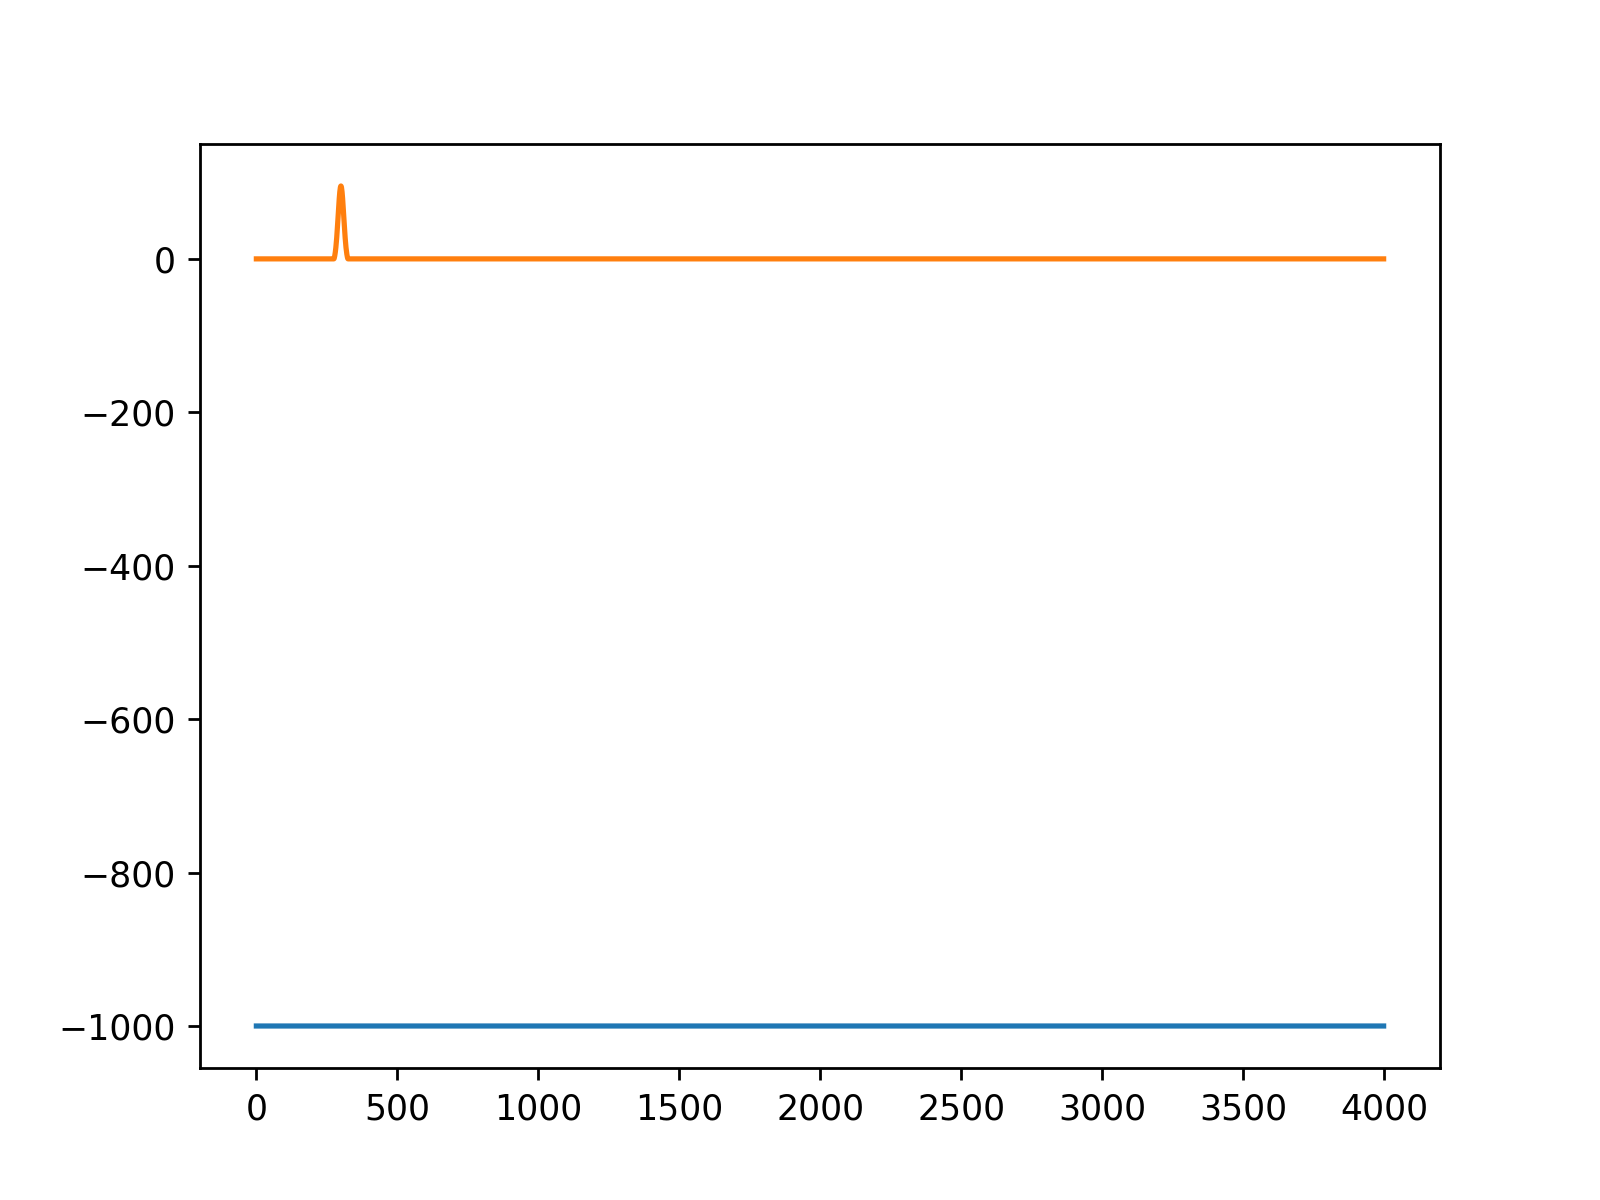

In [56]:
sizex, sizey = 400,200
oned = {
    'h': np.float32(1000*np.ones((sizex,sizey))),
    'n': np.float32(1*lingauss((sizex, sizey), 10, 300)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(50),
    'dy': np.float32(50),
    'dt': np.float32(0.1),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}
plt.figure()
plt.plot(-oned['h'][:,5])
plt.plot(oned['n'][:,5]*100)
plt.show()

In [ ]:
# # fast weighted linear combination kernels for different numbers of items

# @nb.vectorize(['float32(float32,float32,float32,float32)'],target='cuda')
# def lin_comb_2(v1, v2, w1, w2):
#     return v1*w1 + v2*w2
# @nb.vectorize(['float32(float32,float32,float32,float32,float32,float32)'],target='cuda')
# def lin_comb_3(v1, v2, v3, w1, w2, w3):
#     return v1*w1 + v2*w2 + v3*w3
# @nb.vectorize(['float32(float32,float32,float32,float32,float32,float32,float32,float32)'],target='cuda')
# def lin_comb_4(v1, v2, v3, v4, w1, w2, w3, w4):
#     return v1*w1 + v2*w2 + v3*w3 + v4*w4
# @nb.vectorize(['float32(float32,float32,float32,float32,float32,float32,float32,float32,float32,float32)'],target='cuda')
# def lin_comb_5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5):
#     return v1*w1 + v2*w2 + v3*w3 + v4*w4 + v5*w5


# @nb.numba.jit('void(float32[:,:],float32[:,:],float32,float32,float32[:,:])')
# def lincomb2(v1, v2, w1, w2, out):
#     out[:,:] = lin_comb_2(v1, v2, w1, w2)
# @nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32[:,:])')
# def lincomb3(v1, v2, v3, w1, w2, w3, out):
#     out[:,:] = lin_comb_3(v1, v2, v3, w1, w2, w3)
# @nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32[:,:])')
# def lincomb4(v1, v2, v3, v4, w1, w2, w3, w4, out):
#     out[:,:] = lin_comb_4(v1, v2, v3, v4, w1, w2, w3, w4)
# @nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32,float32[:,:])')
# def lincomb5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5, out):
#     out[:,:] = lin_comb_5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5)
    
  

In [26]:
def lin_comb4_thread(v1, v2, v3, v4, w1, w2, w3, w4, out):
    iy ,jx= cuda.grid(2) 
    if iy<out.shape[1] and jx<out.shape[0]:
        out[jx,iy] = w1*v1[jx,iy] + w2*v2[jx,iy] + w3*v3[jx,iy] + w4*v4[jx,iy]
cudacompilelc4 = nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32[:,:])')
lincomb4_cuda = cudacompilelc4(lin_comb4_thread)

def lin_comb5_thread(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5, out):
    iy ,jx= cuda.grid(2) 
    if iy<out.shape[1] and jx<out.shape[0]:
        out[jx,iy] = w1*v1[jx,iy] + w2*v2[jx,iy] + w3*v3[jx,iy] +\
        w4*v4[jx,iy] + w5*v5[jx,iy]
cudacompilelc5 = nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32,float32[:,:])')
lincomb5_cuda = cudacompilelc5(lin_comb5_thread)

# def lin_comb_master_thread(vs, ws, out):
#     i,j = nb.cuda.grid(2)
#     tmp[i,j] = 0
#     for n, v in enumerate(vs):
#         tmp[i,j] += v[i,j]+ws[n]
#     out[i,j] = tmp[i,j]
# cudacompilelc = nb.cuda.jit('void(float32[:],float32[:,:,:],float32[:,:])')
# lincombmaster_cuda = cudacompilelc(lin_comb_master_thread)

def lin_comb4(v1, v2, v3, v4, w1, w2, w3, w4, out):
    threadblock = (32,8)
    gridx = (out.shape[1]+threadblock[1]-1)//threadblock[1]
    gridy = (out.shape[0]+threadblock[0]-1)//threadblock[0]
    lincomb4_cuda[(gridx,gridy),(threadblock)](v1, v2, v3, v4, w1, w2, w3, w4, out)
    

def lin_comb5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5, out):
    threadblock = (32,8)
    gridx = (out.shape[1]+threadblock[1]-1)//threadblock[1]
    gridy = (out.shape[0]+threadblock[0]-1)//threadblock[0]
    lincomb5_cuda[(gridx,gridy),(threadblock)](v1, v2, v3, v4, v5, w1, w2, w3, w4, w5, out)

def max_cuda_thread(n, maxn):
    iy ,jx= cuda.grid(2) 
    if jx<maxn.shape[0] and iy<maxn.shape[1]:
        maxn[jx,iy] = max(maxn[jx,iy], n[jx,iy])
cudacompilemax = nb.cuda.jit('void(float32[:,:],float32[:,:])')
max_cuda = cudacompilemax(max_cuda_thread)

def cudamax(n,maxn):
    threadblock = (32,8)
    gridx = (maxn.shape[1]+threadblock[1]-1)//threadblock[1]
    gridy = (maxn.shape[0]+threadblock[0]-1)//threadblock[0]
    max_cuda[(gridx,gridy),(threadblock)](n,maxn)

In [27]:
#@nb.cuda.jit(fastmath=True,device=True)
def genfb_py(h, n, u, v, f, dt, dx, dy,\
          du,dv,dn, gridu,gridv,gridn, threadblock,\
          beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0.3, \
          dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
          grav=True, cori=True, advx=True, advy=True, attn=True,\
            ): # generalized forward backward feedback timestep
    """
        generalized forward backward predictor corrector
    """
   
    p5   = np.float32(0.5)
    one  = np.float32(1)
    p32  = np.float32(1.5)
    beta = np.float32(beta)
    eps  = np.float32(eps)
    gamma= np.float32(gamma)
    mu = np.float32(mu)
    nu = np.float32(nu)
    
    dn_m1,dn_m2,dn_m0 = dn[0], dn[1], dn[2]     # unpack  
    dndt_x[gridn, threadblock](h, n, u, v, dx, dy, dn_m0)
    # must do the following before the u and v !
    #    n1 = n + ((p32+beta)* dn_m0 - (p5+beta+beta)* dn_m1+ (beta)* dn_m2)*dt
    lincomb4_cuda[gridn,threadblock](n, dn_m0, dn_m1, dn_m2,\
                                     one, (p32+beta)*dt, -(p5+beta+beta)*dt, (beta)*dt, n)
    du_m0,du_m1,du_m2,du_p1 = du[0], du[1], du[2], du[3]     # unpack
    dudt_x[gridu, threadblock](h, n, f, u, v, dx, dy, du_p1,\
                               grav, cori, advx, advy, attn,nu,mu)
    dv_m0,dv_m1,dv_m2,dv_p1 = dv[0], dv[1], dv[2], dv[3]     # unpack   
    dvdt_x[gridv, threadblock](h, n, f, u, v, dx, dy, dv_p1,\
                               grav, cori, advx, advy, attn,nu,mu)


    #u1 = u+ ((p5+gamma+eps+eps)*du_p1 +(p5-gamma-gamma-eps-eps-eps)*du_m0 +gamma*du_m1+eps*du_m2)*dt
    lincomb5_cuda[gridu,threadblock](u, du_p1, du_m0, du_m1, du_m2,\
                one, (p5+gamma+eps+eps)*dt, (p5-gamma-gamma-eps-eps-eps)*dt, \
                                     gamma*dt, eps*dt, u)

    #v1 = v+ ((p5+gamma+eps+eps)*dv_p1 +(p5-gamma-gamma-eps-eps-eps)*dv_m0 +gamma*dv_m1+eps*dv_m2)*dt
    lincomb5_cuda[gridv,threadblock](v, dv_p1, dv_m0, dv_m1, dv_m2,\
                one, (p5+gamma+eps+eps)*dt, (p5-gamma-gamma-eps-eps-eps)*dt, \
                                     gamma*dt, eps*dt, v)
   # lincomb5_cuda[gridv,threadblock](v, dv_p1, dv_m0, dv_m1, dv_m2, \
    #                                 one, one*dt, np.float32(0.0), np.float32(0.0), np.float32(0.0), v)


    dv = ( dv_p1,dv_m0,dv_m1,dv_m2 )
    du = ( du_p1,du_m0,du_m1,du_m2 )
    dn = ( dn_m0,dn_m1,dn_m2 )
    return  du, dv, dn

## Simulation driver 
the simulation driver iterates the time steppers for a defined period of time. This iteratively produces the state of the whole ocean region in the state variables of height (n) and velocity (u,v) at each grid point.

Snapshots of the height is kept periodically and stored into a harddisk mapped virtual memory array for later conversion to animation or images.  

The maximum height at every grid cell is recorded.

### GPU and CPU versions
since the memory and thread management is different on the GPU and CPU there are two different versions of the simulator. 

In [54]:
def simulate_cuda(initstate, t, timestep=genfb_py, nttname = False, \
             bounds = [1, 1, 1, 1], saveinterval=10,\
             drive=donothing, \
             beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0, \
             dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
             grav=True, cori=True, advx=True, advy=True, attn=True): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (n through time) np.memmap,
            maxn (the maximum value of n over the duration at each point) np.array,
            #minn (the minimum value of n over the duration at each point) np.array,
            #timemax (the number of seconds until the maximum height at each point) np.array
    """
    print("simulate start")
    bounds = np.asarray(bounds, dtype=np.float32)
    h, n, u, v, f, dx, dy, dt = [initstate[k] for k in ('h', 'n', 'u', 'v', 'lat', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    
#     h[np.logical_and(np.greater(h, -0.1), np.less(h, 0.2))] = np.float32(0.1)
    f = np.float32(((2*2*np.pi*np.sin(f*np.pi/180))/(24*3600))[:,np.newaxis])
    

    
    
    nu = (dx+dy)/1000
    #     state = initstate
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    
    saveinterval = np.int(saveinterval//dt)
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.zeros((np.int(np.ceil(itrs/saveinterval)),)+n.shape, dtype=np.float32)
#     ntt = np.memmap(str(nttname)+'_eed', dtype='float32', mode='w+', shape=(itrs,)+n.shape)
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
#     minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
#     timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    
    coastx = np.less(h, landthresh) # where the reflective condition is enforced on the coast

    coastx = np.float32(coastx)
    
    
    ch     = nb.cuda.to_device(h)
    cn     = nb.cuda.to_device(n)
    cu     = nb.cuda.to_device(u)
    cv     = nb.cuda.to_device(v)
#     cout = nb.cuda.to_device(uout)
#     cnout = nb.cuda.to_device(nout)
    cf     = nb.cuda.to_device(f)
    ccoastx= nb.cuda.to_device(coastx)
    cmaxn  = nb.cuda.to_device(maxn)

    threadblock=(16,16)
  #  threadblock=(32,8)   # this fails but  Why?????????????????????????????????????
                        # no errors, just nothing at all updates on GPU
#     gridu = ( (u.shape[0]+threadblock[0]-1)//threadblock[0],
#               (u.shape[1]+threadblock[1]-1)//threadblock[1])
#     gridv = ( (v.shape[0]+threadblock[0]-1)//threadblock[0],
#               (v.shape[1]+threadblock[1]-1)//threadblock[1])
#     gridn = ( (n.shape[0]+threadblock[0]-1)//threadblock[0],
#               (n.shape[1]+threadblock[1]-1)//threadblock[1])
    # other order.
    gridu = ( (u.shape[1]+threadblock[1]-1)//threadblock[1],
              (u.shape[0]+threadblock[0]-1)//threadblock[0])
    gridv = ( (v.shape[1]+threadblock[1]-1)//threadblock[1],
              (v.shape[0]+threadblock[0]-1)//threadblock[0])
    gridn = ( (n.shape[1]+threadblock[1]-1)//threadblock[1],
              (n.shape[0]+threadblock[0]-1)//threadblock[0])
  
    dudt_x = dudt_drive_cuda#[gridu,threadblock]  # these override the inputs
    dvdt_x = dvdt_drive_cuda#[gridv,threadblock]
    dndt_x = dndt_drive_cuda#[gridn,threadblock]

    #create  du,dv,dn on device
    du0 =  nb.cuda.device_array_like(u)
    dv0 = nb.cuda.device_array_like(v)
    dn0 =  nb.cuda.device_array_like(n)
 
    print ('dndt-cuda attrs ', dndt_x._func.get().attrs)
    print ('dudt-cuda attrs ', dudt_x._func.get().attrs)
    print ('dvdt-cuda attrs ', dvdt_x._func.get().attrs)
    
    # load in the intial values
    print ("initializing")
    dndt_x[gridn,threadblock](ch, cn,     cu, cv, dx, dy, dn0)
    dvdt_x[gridv,threadblock](ch, cn, cf, cu, cv, dx, dy, dv0,grav, cori, advx, advy, attn,nu,mu)
    dudt_x[gridu,threadblock](ch, cn, cf, cu, cv, dx, dy, du0,grav, cori, advx, advy, attn,nu,mu)
    
    # create the tuples 
    cdu = (du0, nb.cuda.device_array_like(du0), \
           nb.cuda.device_array_like(du0), \
           nb.cuda.device_array_like(du0) )
    
    cdv = (dv0,  nb.cuda.to_device(dv0),\
           nb.cuda.to_device(dv0), \
           nb.cuda.to_device(dv0))
    
    cdn = (dn0, nb.cuda.device_array_like(dn0),\
           nb.cuda.device_array_like(dn0))
    
    # initialize the tuples on the device
    for d in cdn:
        d[:,:] =  dn0[:,:]
        
    for d in cdv:
        d[:,:] = dv0[:,:]
           
    for d in cdu:
        d[:,:] = du0[:,:]
    
    land   =   land_cuda#[(gridu[0],gridv[1]),threadblock]  # is this grid right 
    border = border_cuda#[(gridu[0],gridv[1]),threadblock]
    
    nb.cuda.synchronize()  # needed?
    print("threadblock,grid",threadblock,gridn,gridu,gridv)
    print('simulating...')
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            if itr%saveinterval == 0:
                #cuda.synchronize() # is this needed?
                ntt[np.int(itr/saveinterval),:,:] = cn.copy_to_host()
          
            cdu, cdv, cdn = timestep(ch, cn, cu, cv, cf, dt, dx, dy,\
                        cdu,cdv,cdn,gridu,gridv,gridn,threadblock, \
                        0.281105, 0.013, 0.0880, 0.3, 0.3, \
                        dudt_x, dvdt_x, dndt_x, \
                        grav=True, cori=True, advx=True, advy=True, attn=True \
                   ) # pushes n, u, v one step into the future

        #    land_cuda[gridn,threadblock](ch, cn, cu, cv, ccoastx) # how to handle land/coast
         #   border_cuda(cn, cu, cv, 16, bounds) 
         #   drive(ch, cn, cu, cv, cf, dt, dx, dy, nu, ccoastx, cbounds, mu, itr)
            cudamax(cn,cmaxn)
        print('simulation complete')
    except Exception as e:
        print('timestep: ', itr)
        raise e
    maxn =  cmaxn.copy_to_host()
    
    return ntt, maxn#.copy_to_host()#, minn, timemax # return surface height through time and maximum heights

speed 10.0
grids (1, 1) (1, 1) (1, 1)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
dvdt-cuda attrs  FuncAttr(regs=28, shared=0, local=0, const=0, maxthreads=1024)
initializing
dndt + lincom  check
 lincom  cuda - numba err 5.9604645e-08
transpose check cuda 0.0
cdv0
[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.07555694 -0.01619626  0.04792215 -0.1983417   0.01719346
   0.12434007  0.        ]
 [ 0.         -0.04413512 -0.18680657  0.17247608 -0.1178768  -0.06286427
   0.14752091  0.        ]
 [ 0.         -0.03739104 -0.00022439  0.01152294 -0.02152421  0.00076848
   0.02097193  0.        ]
 [ 0.         -0.1723648   0.0374239   0.08472181 -0.02197441 -0.14745377
   0.13177447  0.        ]
 [ 0.         -0.09069749 -0.02429399  0.03669143 -0.09593383 -0.01273598
   0.18019119 

<IPython.core.display.Javascript object>


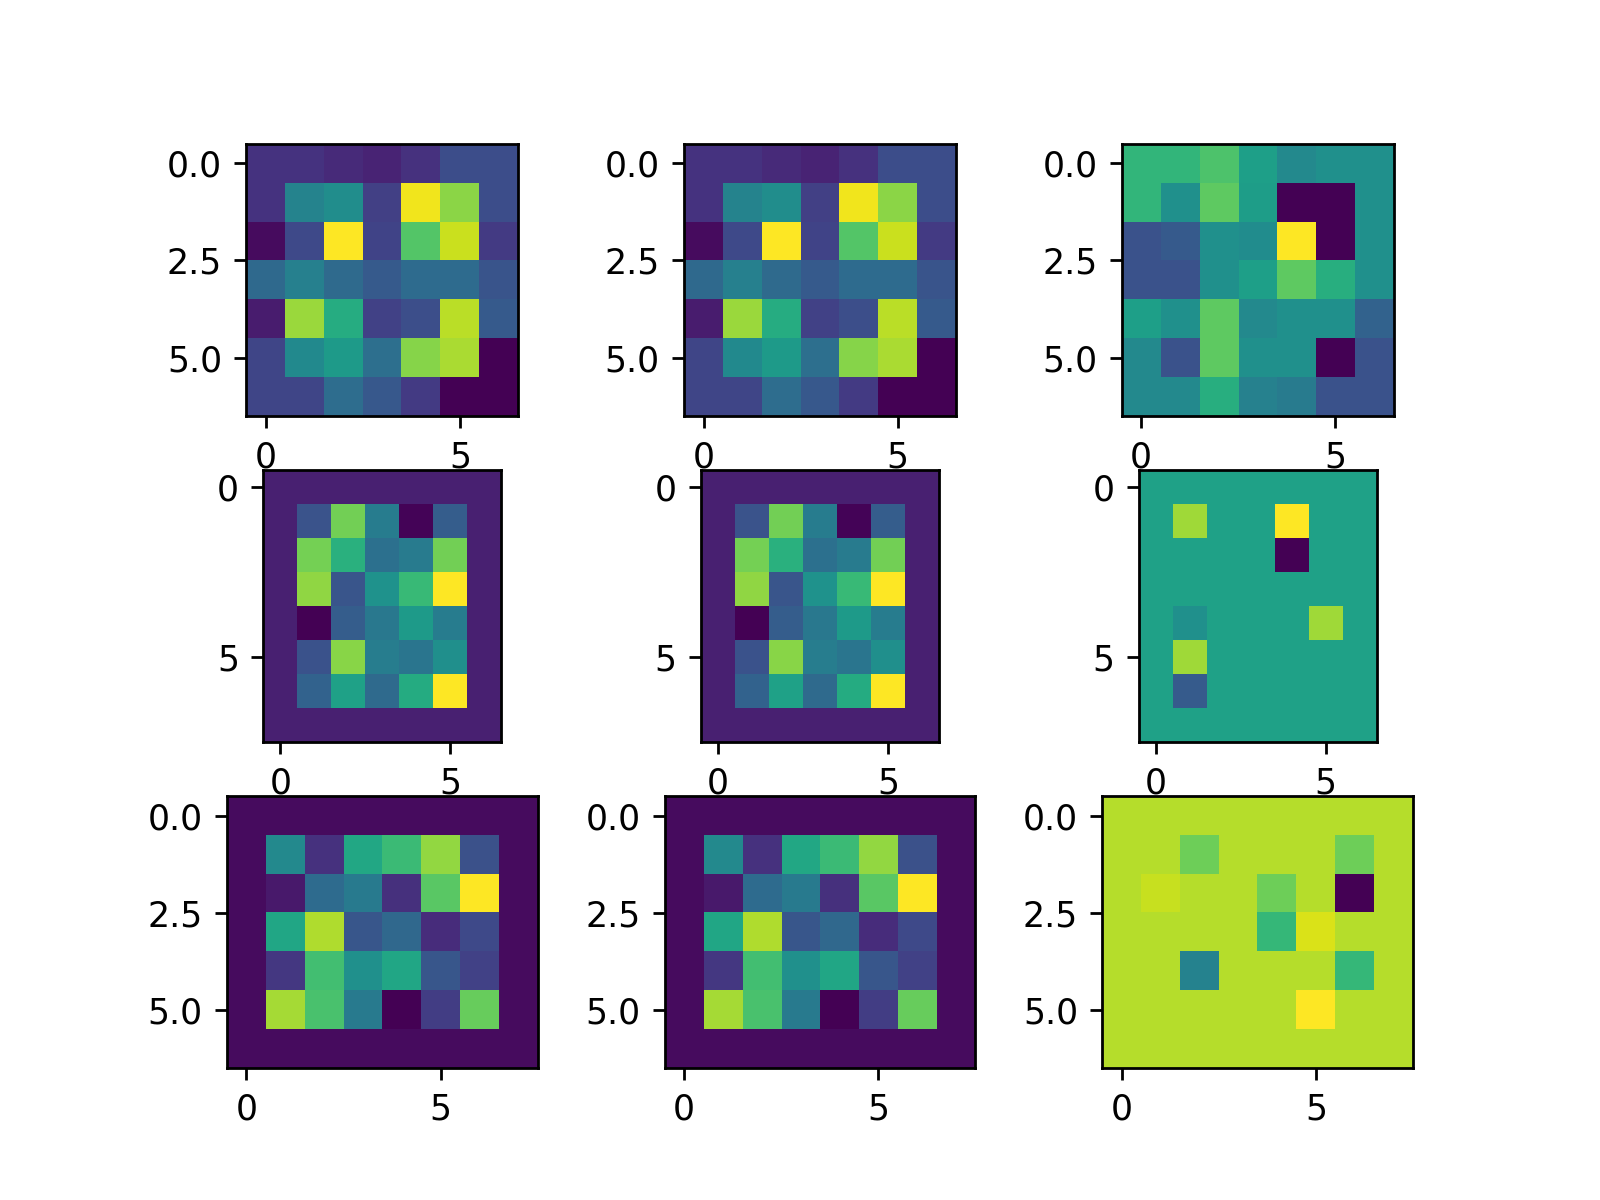

NUV 0 type  0 3.9561039e-07
[[ 1.8626451e-08  1.8626451e-08  2.6077032e-08  7.4505806e-09
  -3.7252903e-09  0.0000000e+00  0.0000000e+00]
 [ 1.8626451e-08  0.0000000e+00  2.9802322e-08  6.5192580e-09
  -5.9604645e-08 -5.9604645e-08  0.0000000e+00]
 [-2.9802322e-08 -2.6077032e-08  0.0000000e+00 -1.8626451e-09
   5.9604645e-08 -5.9604645e-08  0.0000000e+00]
 [-2.9802322e-08 -2.9802322e-08  0.0000000e+00  7.4505806e-09
   2.9802322e-08  1.4901161e-08  0.0000000e+00]
 [ 7.4505806e-09  0.0000000e+00  2.9802322e-08 -3.7252903e-09
   0.0000000e+00  0.0000000e+00 -2.2351742e-08]
 [-3.7252903e-09 -2.9802322e-08  2.9802322e-08  0.0000000e+00
   0.0000000e+00 -5.9604645e-08 -2.9802322e-08]
 [-3.7252903e-09 -3.7252903e-09  1.4901161e-08 -7.4505806e-09
  -1.0244548e-08 -2.9802322e-08 -2.9802322e-08]]
(array([[-0.03300045, -0.03300045, -0.06110141, -0.0856147 , -0.03648981,
         0.06747637,  0.06747637],
       [-0.03300045,  0.2996861 ,  0.34723568,  0.0143853 ,  0.885952  ,
         0.7155532 

<IPython.core.display.Javascript object>


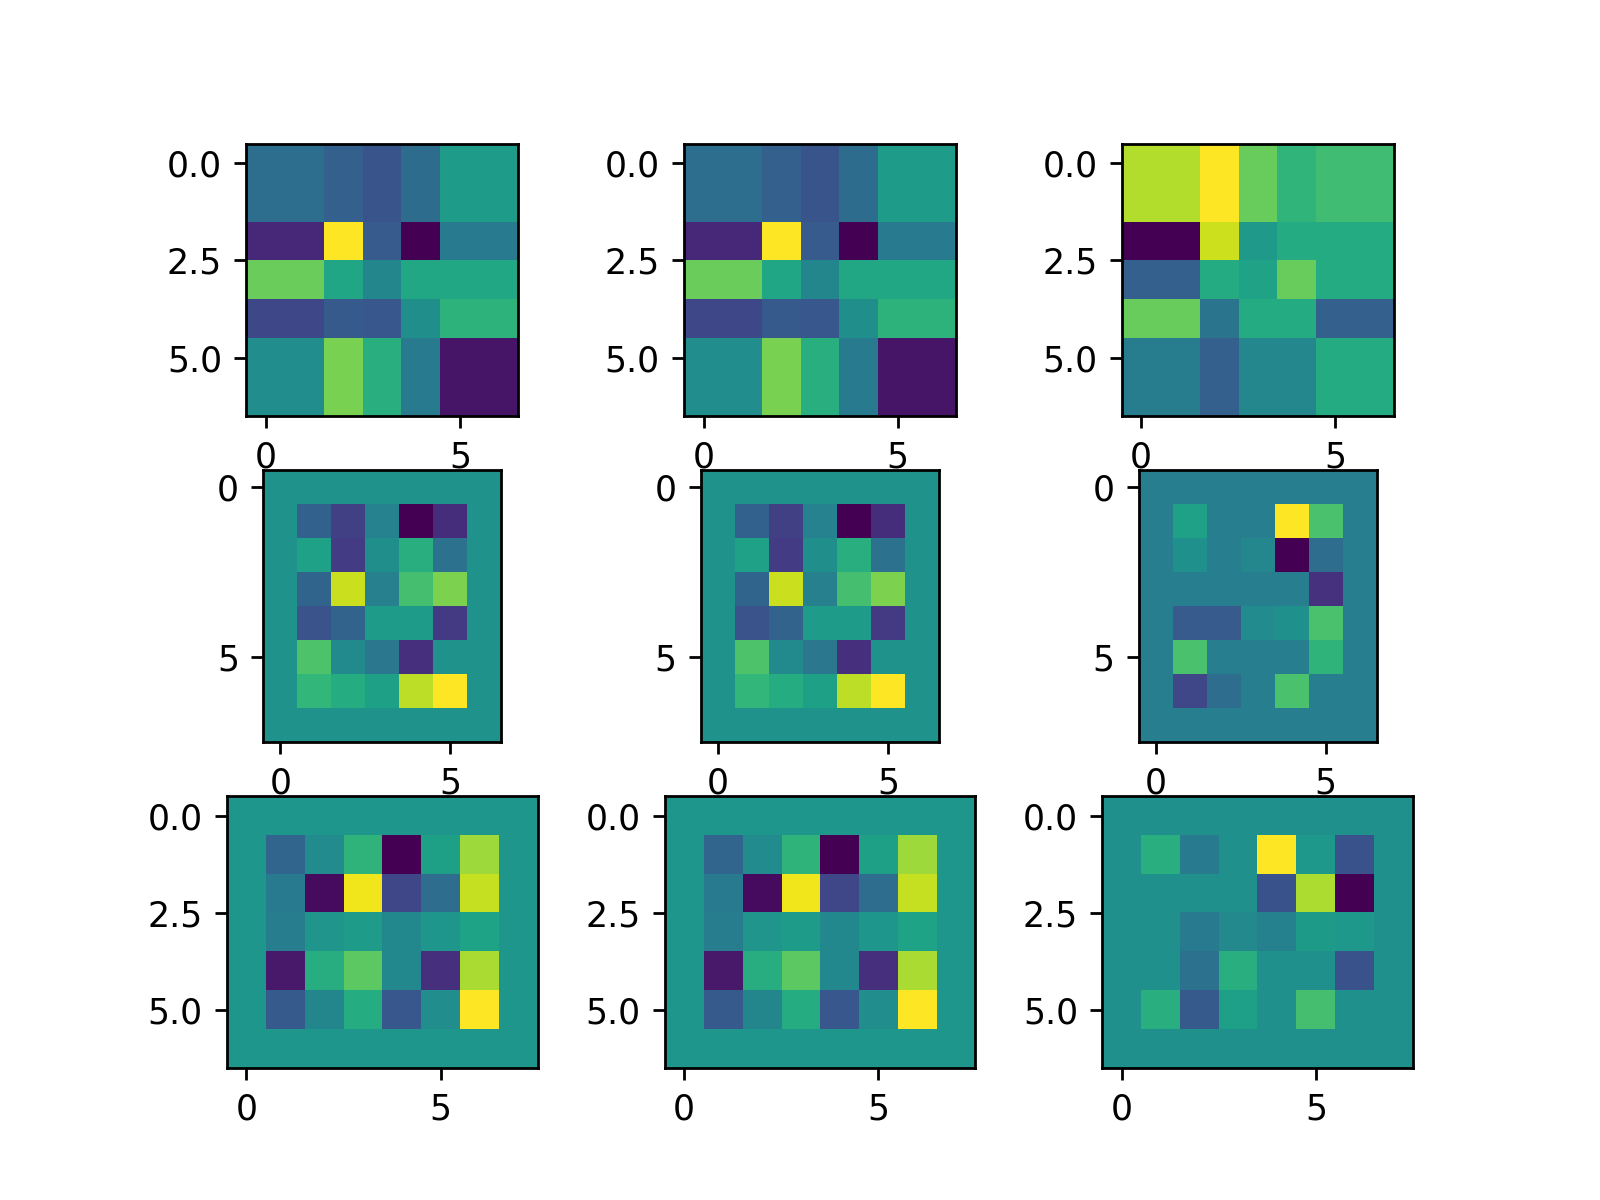

DN Du DV 1 type  0 3.279819e-07
[[ 1.3038516e-08  1.3038516e-08  1.8626451e-08  7.4505806e-09
   1.8626451e-09  3.7252903e-09  3.7252903e-09]
 [ 1.3038516e-08  1.3038516e-08  1.8626451e-08  7.4505806e-09
   1.8626451e-09  3.7252903e-09  3.7252903e-09]
 [-2.9802322e-08 -2.9802322e-08  1.4901161e-08 -3.7252903e-09
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.4901161e-08 -1.4901161e-08  0.0000000e+00 -1.8626451e-09
   7.4505806e-09  0.0000000e+00  0.0000000e+00]
 [ 7.4505806e-09  7.4505806e-09 -1.1175871e-08  0.0000000e+00
   0.0000000e+00 -1.4901161e-08 -1.4901161e-08]
 [-9.3132257e-09 -9.3132257e-09 -1.4901161e-08 -7.4505806e-09
  -7.4505806e-09  0.0000000e+00  0.0000000e+00]
 [-9.3132257e-09 -9.3132257e-09 -1.4901161e-08 -7.4505806e-09
  -7.4505806e-09  0.0000000e+00  0.0000000e+00]]
(array([[-0.02640036, -0.02640036, -0.04888113, -0.06849176, -0.02919185,
         0.0539811 ,  0.0539811 ],
       [-0.02640036, -0.02640036, -0.04888113, -0.06849176, -0.02919185,
         0.0539

<IPython.core.display.Javascript object>


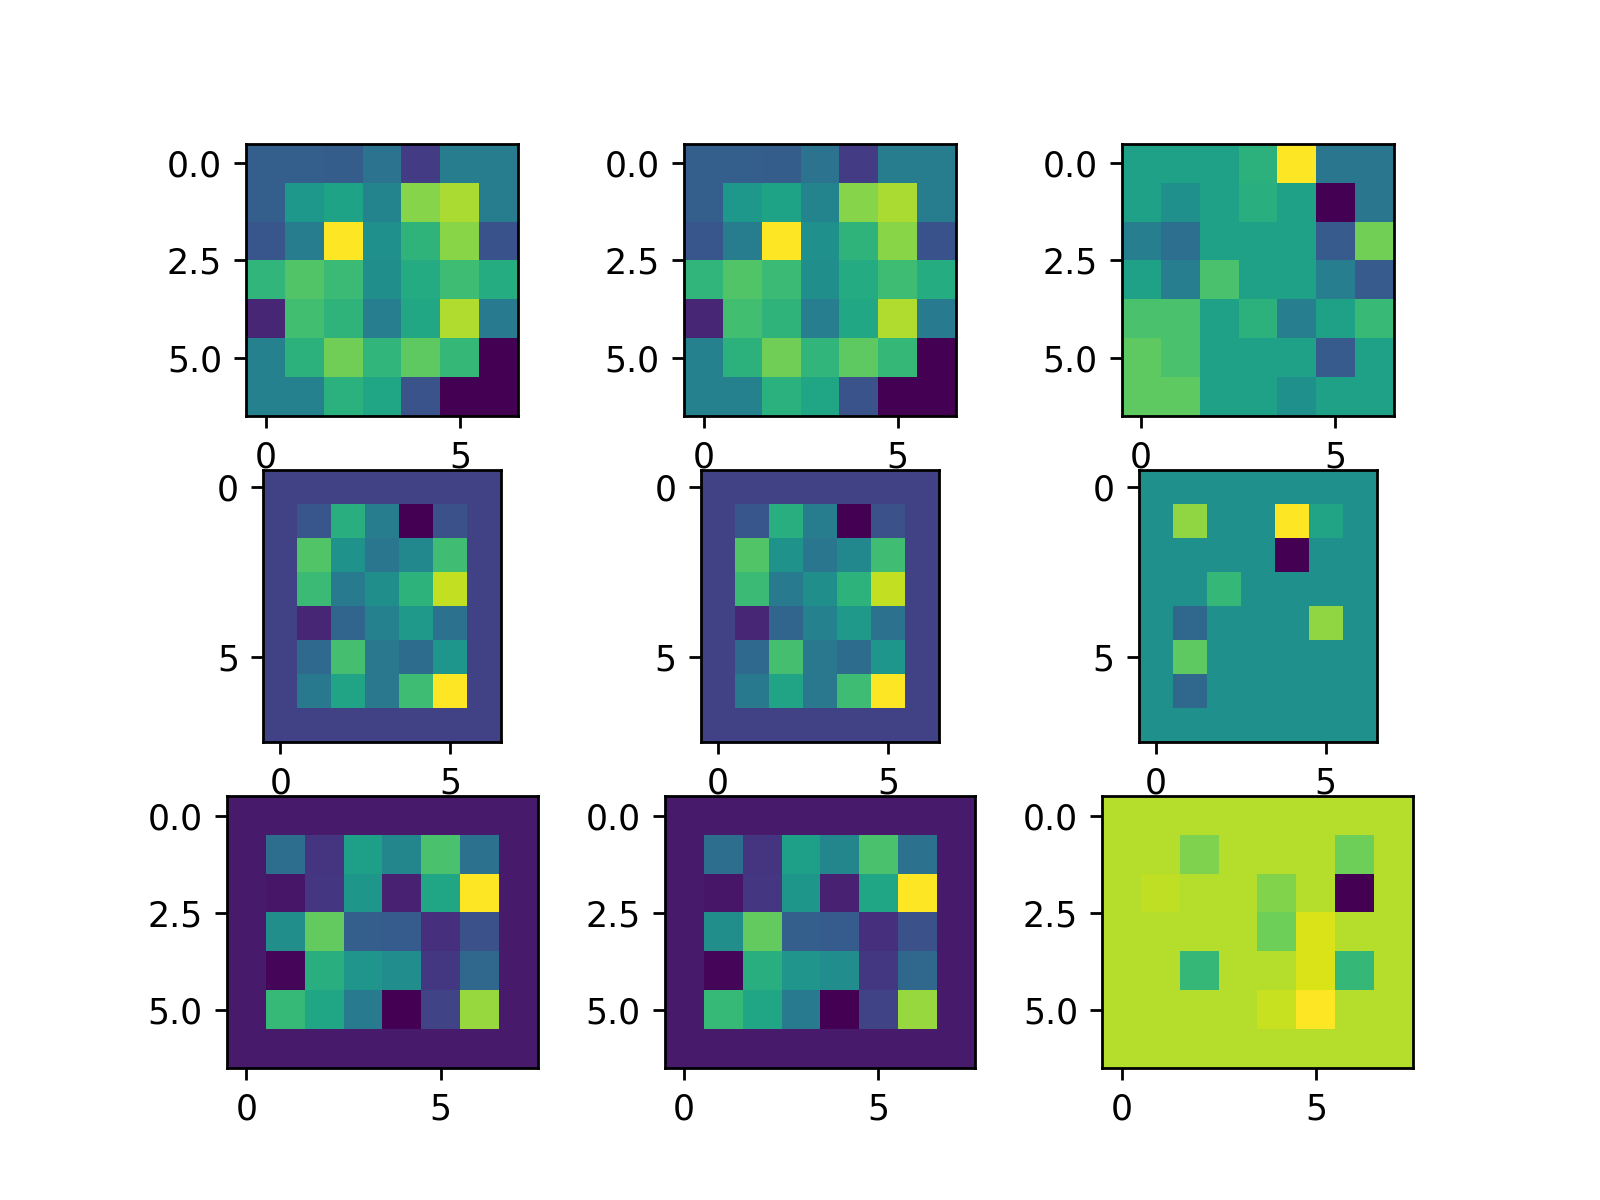

NUV 2 type  0 1.026772e-06
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.4901161e-08
   8.9406967e-08 -3.7252903e-08 -3.7252903e-08]
 [ 0.0000000e+00 -1.4901161e-08  0.0000000e+00  1.1175871e-08
   0.0000000e+00 -1.1920929e-07 -3.7252903e-08]
 [-2.9802322e-08 -4.2840838e-08  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -5.9604645e-08  4.4703484e-08]
 [ 0.0000000e+00 -2.9802322e-08  2.9802322e-08  0.0000000e+00
   0.0000000e+00 -2.9802322e-08 -5.9604645e-08]
 [ 2.9802322e-08  2.9802322e-08  0.0000000e+00  1.4901161e-08
  -2.9802322e-08  0.0000000e+00  2.1420419e-08]
 [ 3.7252903e-08  2.9802322e-08  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -5.9604645e-08  0.0000000e+00]
 [ 3.7252903e-08  3.7252903e-08  0.0000000e+00  0.0000000e+00
  -1.4901161e-08  0.0000000e+00  0.0000000e+00]]
(array([[-0.1488267 , -0.1488267 , -0.15900853, -0.0385738 , -0.33036882,
         0.02454342,  0.02454342],
       [-0.1488267 ,  0.18385984,  0.24932855,  0.0614262 ,  0.59207296,
         0.67262024,

<IPython.core.display.Javascript object>


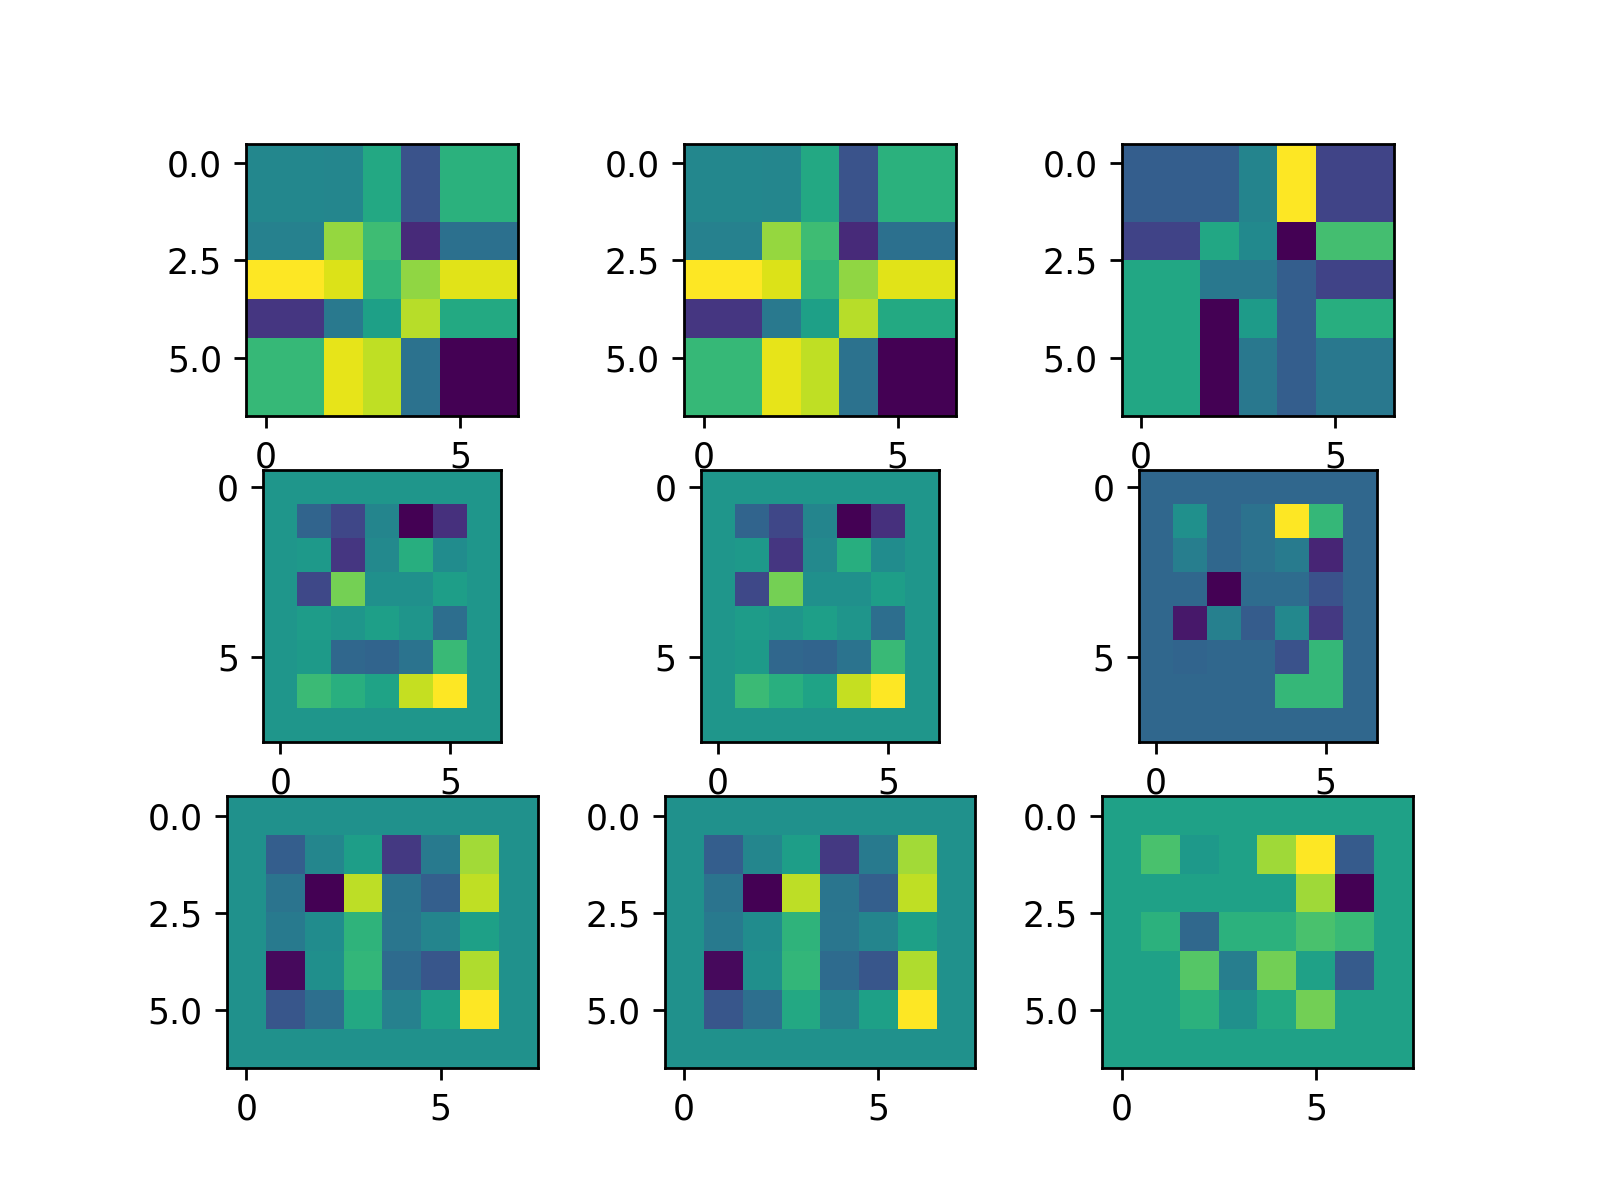

DN Du DV 3 type  0 7.6868594e-07
[[-7.4505806e-09 -7.4505806e-09 -7.4505806e-09  3.7252903e-09
   4.4703484e-08 -1.4435500e-08 -1.4435500e-08]
 [-7.4505806e-09 -7.4505806e-09 -7.4505806e-09  3.7252903e-09
   4.4703484e-08 -1.4435500e-08 -1.4435500e-08]
 [-1.4901161e-08 -1.4901161e-08  1.4901161e-08  5.5879354e-09
  -2.9802322e-08  2.2351742e-08  2.2351742e-08]
 [ 1.4901161e-08  1.4901161e-08  0.0000000e+00  0.0000000e+00
  -7.4505806e-09 -1.4901161e-08 -1.4901161e-08]
 [ 1.4901161e-08  1.4901161e-08 -2.9802322e-08  1.1175871e-08
  -7.4505806e-09  1.6763806e-08  1.6763806e-08]
 [ 1.4901161e-08  1.4901161e-08 -2.9802322e-08  0.0000000e+00
  -7.4505806e-09  0.0000000e+00  0.0000000e+00]
 [ 1.4901161e-08  1.4901161e-08 -2.9802322e-08  0.0000000e+00
  -7.4505806e-09  0.0000000e+00  0.0000000e+00]]
(array([[-0.06360235, -0.06360235, -0.06541277, -0.00890826, -0.1448006 ,
         0.00438972,  0.00438972],
       [-0.06360235, -0.06360235, -0.06541277, -0.00890826, -0.1448006 ,
         0.004

=====  NUV ==========


<IPython.core.display.Javascript object>


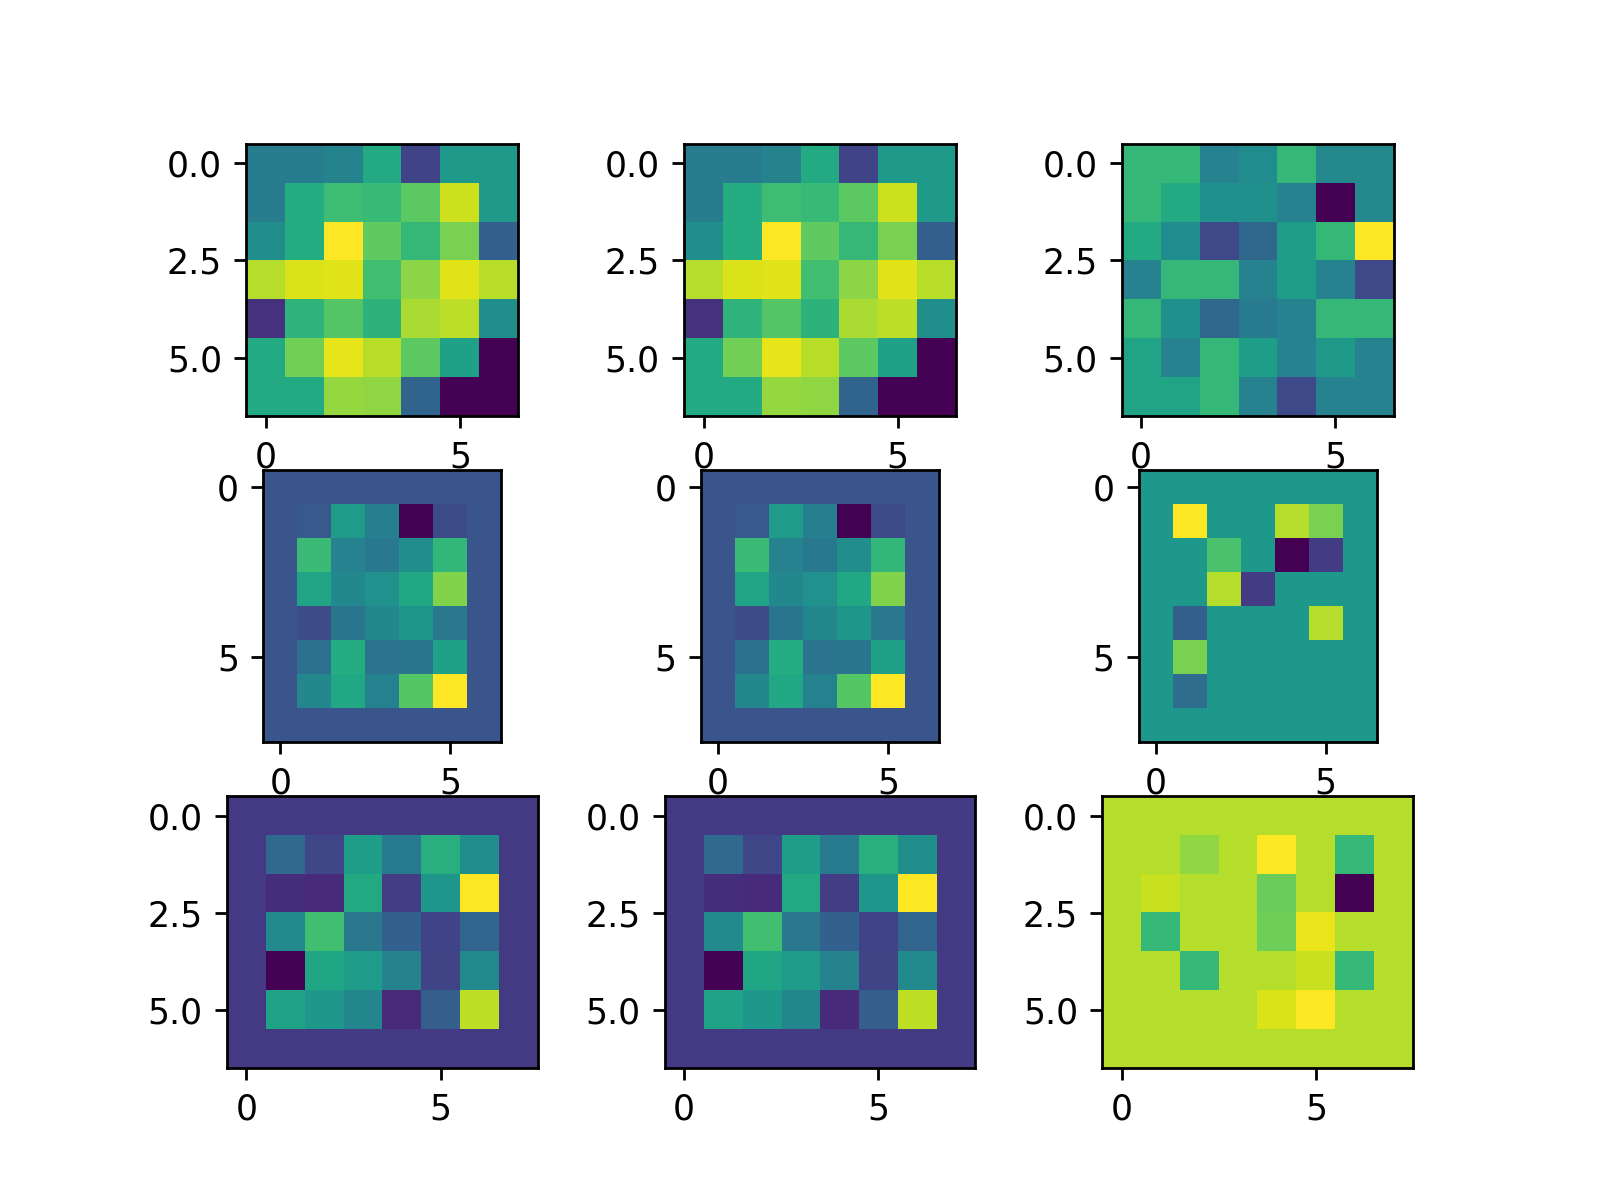

NUV 4 type  0 5.7177385e-07
[[ 5.9604645e-08  5.9604645e-08  0.0000000e+00  1.1175871e-08
   5.9604645e-08  7.4505806e-09  7.4505806e-09]
 [ 5.9604645e-08  4.4703484e-08  1.4901161e-08  1.4901161e-08
   0.0000000e+00 -1.1920929e-07  7.4505806e-09]
 [ 4.4703484e-08  1.1175871e-08 -5.9604645e-08 -2.9802322e-08
   2.9802322e-08  5.9604645e-08  1.4901161e-07]
 [ 0.0000000e+00  5.9604645e-08  5.9604645e-08  0.0000000e+00
   2.9802322e-08  0.0000000e+00 -5.9604645e-08]
 [ 5.9604645e-08  1.4901161e-08 -2.9802322e-08 -7.4505806e-09
   0.0000000e+00  5.9604645e-08  5.9604645e-08]
 [ 3.7252903e-08  0.0000000e+00  5.9604645e-08  2.9802322e-08
   0.0000000e+00  2.6077032e-08  0.0000000e+00]
 [ 3.7252903e-08  3.7252903e-08  5.9604645e-08  0.0000000e+00
  -5.9604645e-08  0.0000000e+00  0.0000000e+00]]
(array([[-0.29223162, -0.29223162, -0.25163493,  0.02956451, -0.66262513,
        -0.09453171, -0.09453171],
       [-0.29223162,  0.04045494,  0.15670218,  0.12956451,  0.25981668,
         0.55354506

<IPython.core.display.Javascript object>


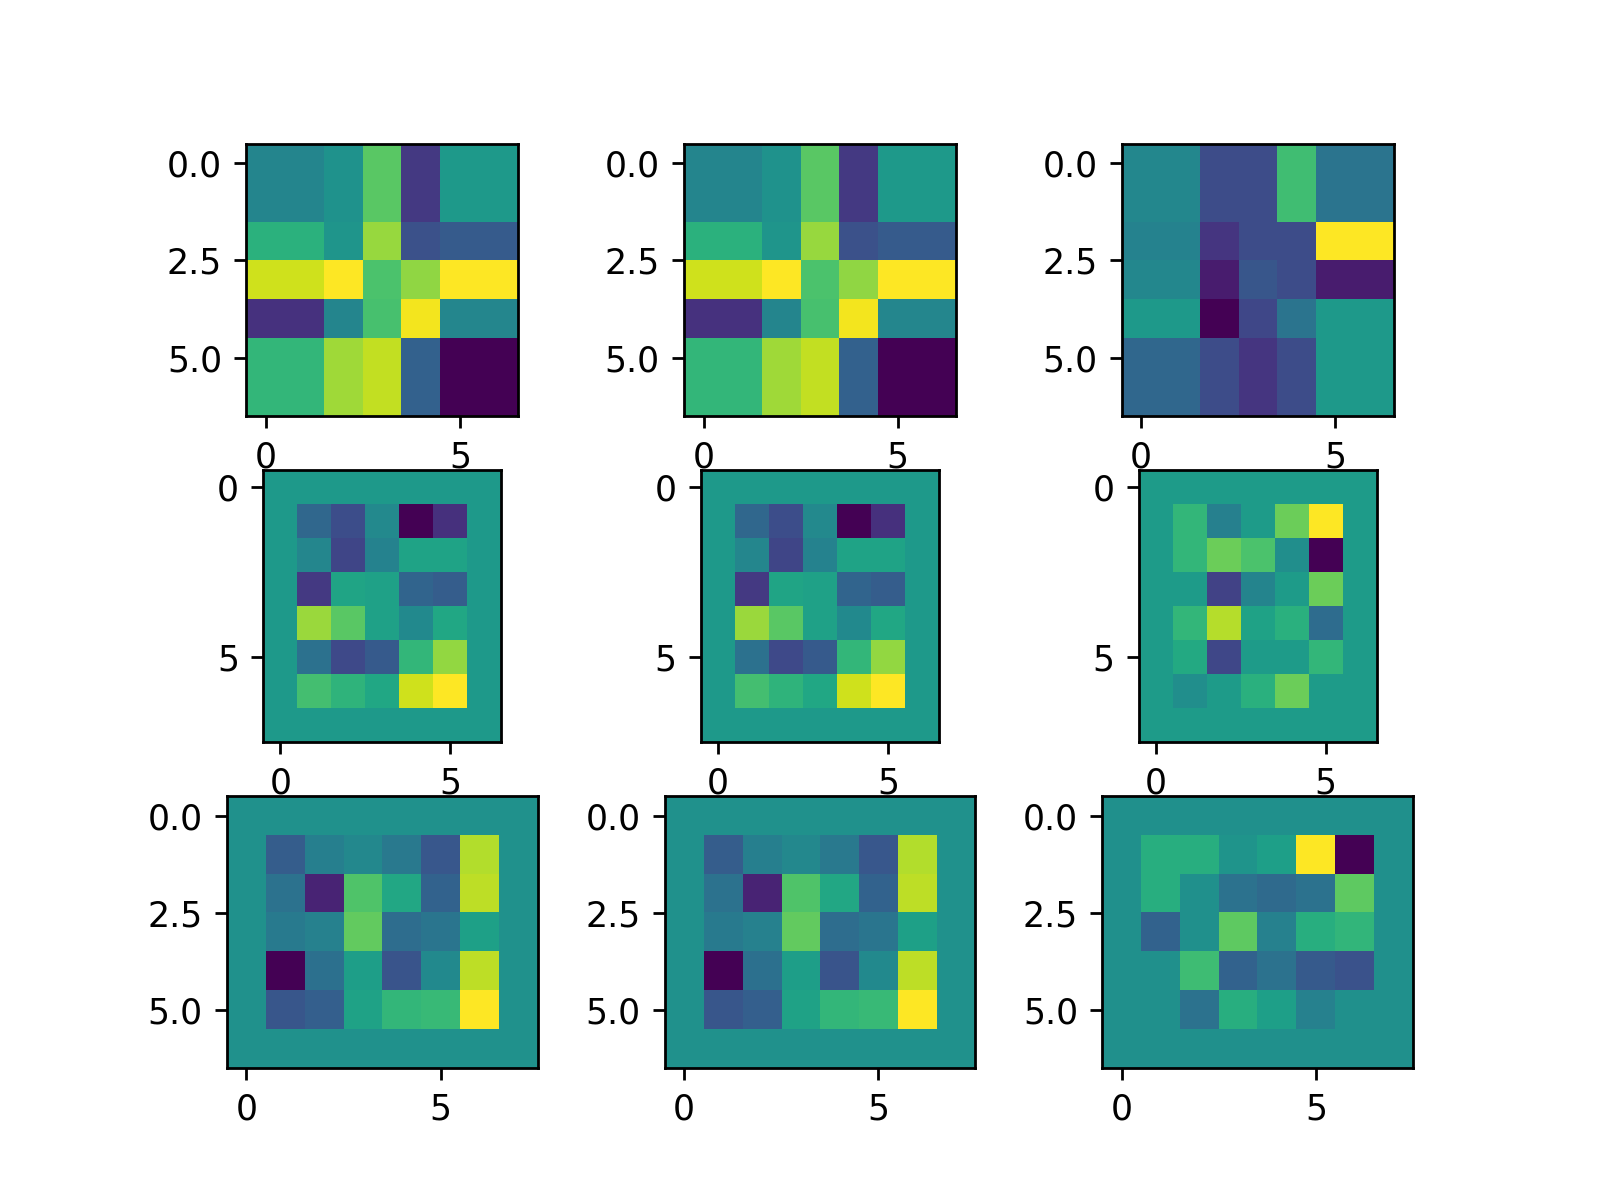

DN Du DV 5 type  0 6.9457894e-07
[[ 2.2351742e-08  2.2351742e-08  0.0000000e+00  0.0000000e+00
   4.4703484e-08  1.4901161e-08  1.4901161e-08]
 [ 2.2351742e-08  2.2351742e-08  0.0000000e+00  0.0000000e+00
   4.4703484e-08  1.4901161e-08  1.4901161e-08]
 [ 2.0489097e-08  2.0489097e-08 -7.4505806e-09  0.0000000e+00
   0.0000000e+00  7.4505806e-08  7.4505806e-08]
 [ 2.2351742e-08  2.2351742e-08 -1.4901161e-08  3.7252903e-09
   0.0000000e+00 -1.4901161e-08 -1.4901161e-08]
 [ 2.9802322e-08  2.9802322e-08 -2.2351742e-08 -1.8626451e-09
   1.4901161e-08  2.9802322e-08  2.9802322e-08]
 [ 1.0011718e-08  1.0011718e-08  0.0000000e+00 -7.4505806e-09
   0.0000000e+00  2.9802322e-08  2.9802322e-08]
 [ 1.0011718e-08  1.0011718e-08  0.0000000e+00 -7.4505806e-09
   0.0000000e+00  2.9802322e-08  2.9802322e-08]]
(array([[-0.09817597, -0.09817597, -0.07289995,  0.03610208, -0.23098452,
        -0.05938541, -0.05938541],
       [-0.09817597, -0.09817597, -0.07289995,  0.03610208, -0.23098452,
        -0.059

In [38]:
#unit test verifying numba nd cuda genfb equivalence
N=7
M=7
beta=np.float32(0.281105)
eps=np.float32(0.013)
gamma=np.float32(0.0880)

h = np.ones((N,M),dtype =np.float32)
h*=10
sped = np.sqrt(10*np.mean(h))
print("speed",sped)
n = np.array(np.random.random((N,M)),dtype =np.float32)
n[n.shape[0]//2,:]=0.1
n[:,n.shape[1]//2]=0.1
n[0,:]=0.0
n[:,0]=0.0
n[-1,:]=0.0
n[:,-1]=0.0


f = np.ones((N,M),dtype =np.float32)
f*=0 #0.001
u = np.array(np.random.random((N+1,M)),dtype =np.float32)
u*=sped/10
u[0,:]=0.0
u[:,0]=0.0
u[-1,:]=0.0
u[:,-1]=0.0
v = np.array(np.random.random((N,M+1)),dtype =np.float32)
v*=sped/10
v[0,:]=0.0
v[:,0]=0.0
v[-1,:]=0.0
v[:,-1]=0.0
 
norig = np.copy(n)
uorig = np.copy(u)
vorig = np.copy(v)
    
ch     = nb.cuda.to_device(h)
cn     = nb.cuda.to_device(n)
cu     = nb.cuda.to_device(u)
cv     = nb.cuda.to_device(v)
cf     = nb.cuda.to_device(f)

cnorig =  nb.cuda.to_device(n)
cvorig =  nb.cuda.to_device(v)
cuorig =  nb.cuda.to_device(u)

threadblock=(16,16)
# gridu = ( (u.shape[0]+threadblock[0]-1)//threadblock[0],
#           (u.shape[1]+threadblock[1]-1)//threadblock[1])
# gridv = ( (v.shape[0]+threadblock[0]-1)//threadblock[0],
#           (v.shape[1]+threadblock[1]-1)//threadblock[1])
# gridn = ( (n.shape[0]+threadblock[0]-1)//threadblock[0],
#           (n.shape[1]+threadblock[1]-1)//threadblock[1])
# other order.
gridu = ( (u.shape[1]+threadblock[1]-1)//threadblock[1],
          (u.shape[0]+threadblock[0]-1)//threadblock[0])

gridv = ( (v.shape[1]+threadblock[1]-1)//threadblock[1],
          (v.shape[0]+threadblock[0]-1)//threadblock[0])

gridn = ( (n.shape[1]+threadblock[1]-1)//threadblock[1],
          (n.shape[0]+threadblock[0]-1)//threadblock[0])

print("grids", gridu,gridv,gridn)
#h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0
dx = dy = np.float32(50.0)
dt = dx/sped/4


dudt_x = dudt_drive_cuda#[gridu,threadblock]  # these override the inputs
dvdt_x = dvdt_drive_cuda#[gridv,threadblock]
dndt_x = dndt_drive_cuda#[gridn,threadblock]

#create  du,dv,dn on device
cdu0 =  nb.cuda.device_array_like(u)
cdu0[:,:]=0.0
print (cdu0.copy_to_host())
#du0[:]=0.0
cdv0 = nb.cuda.device_array_like(v)
#dv0[:]=0.0
cdn0 =  nb.cuda.device_array_like(n)
#dn0[:]=0.0
print ('dvdt-cuda attrs ', dvdt_x._func.get().attrs)

# load in the intial values
print ("initializing")
grav=True
cori=advx=advy=attn=True
nu=mu=0.3


# note cant use transpose for output!


dndt_x[gridn,threadblock](ch, cn,     cu, cv, dx, dy, cdn0)
# propagate n before dudt
lincomb4_cuda[gridn,threadblock](cn, cdn0, cdn0, cdn0,\
                one, (p32+beta)*dt, -(p5+beta+beta)*dt, (beta)*dt, cn)

dvdt_x[gridv,threadblock](ch, cn, cf, cu, cv, dx, dy, cdv0,\
                          grav, cori, advx, advy, attn,nu,mu)

dudt_x[gridu,threadblock](ch, cn, cf, cu, cv, dx, dy, cdu0,\
                          grav, cori, advx, advy, attn,nu,mu)




# create the tuples 
cdu = (cdu0, nb.cuda.device_array_like(cdu0), \
       nb.cuda.device_array_like(cdu0), \
       nb.cuda.device_array_like(cdu0) )

cdv = (cdv0,  nb.cuda.device_array_like(cdv0),\
       nb.cuda.device_array_like(cdv0), \
       nb.cuda.device_array_like(cdv0))

cdn = (cdn0, nb.cuda.device_array_like(cdn0),\
       nb.cuda.device_array_like(cdn0))

# initialize the tuples on the device
for d in cdn:
    d[:,:] =  cdn[0][:,:]

for d in cdv:
    d[:,:] = cdv[0][:,:]

for d in cdu:
    d[:,:] = cdu[0][:,:]

du0 = np.zeros_like(u)
dv0 = np.zeros_like(v)
dn0 = np.zeros_like(n)

   
dndt_drive_numba(h, n, u, v, dx, dy, dn0)  
dn = (dn0, np.copy(dn0), np.copy(dn0))


print ("dndt + lincom  check")
n = n + ((p32+beta)* dn[0] - (p5+beta+beta)* dn[1]+ (beta)* dn[2])*dt


print (" lincom  cuda - numba err", np.max(np.abs(cn.copy_to_host()-n)))

       
       
dudt_drive_numba(h, n, f, u, v, dx, dy, du0, \
                 grav, cori, advx, advy, attn,nu,mu)
du = (du0, np.copy(du0), np.copy(du0), np.copy(du0))

dvdt_drive_numba(h, n, f, u, v, dx, dy, dv0,\
                          grav, cori, advx, advy, attn,nu,mu)
dv = (dv0, np.copy(dv0), np.copy(dv0), np.copy(dv0))



# verify that transpose of U is V of transpose
temp = nb.cuda.device_array_like(u)
dudt_x[gridu,threadblock](ch.T, cn.T, -f.T, cv.T,  cu.T, dy, dx, temp,\
                          grav, cori, advx, advy, attn,nu,mu)
print("transpose check cuda", np.max(np.abs(cdv0-temp.copy_to_host().T)))
print ("cdv0")
print(np.float32(cdv0.copy_to_host()))
print ("cdu(transposed inputs transpose")
print(np.float32(temp.copy_to_host()).T)


temp = np.zeros_like(u)
dudt_drive_numba(h.T, n.T, -f.T,  v.T, u.T, dy, dx, temp,\
                          grav, cori, advx, advy, attn,nu,mu)
print("transpose numba check", np.max(np.abs( dv0-temp.T)))
print ("dv0")
print (dv0)
print ("du(transposed inputs) transposed")
print (temp.T)
print (" ---")       
       
       


v1 = v+ ((p5+gamma+eps+eps)*dv[0] +(p5-gamma-gamma-eps-eps-eps)*dv[1] \
         +gamma*dv[2]+eps*dv[3])*dt
temp = nb.cuda.device_array_like(v)
lincomb5_cuda[gridv,threadblock](cv, cdv[0], cdv[1], cdv[2], cdv[3],\
                one, (p5+gamma+eps+eps)*dt, (p5-gamma-gamma-eps-eps-eps)*dt, \
                              gamma*dt, eps*dt, temp)

print ("lincomb check V",np.max(np.abs(v1-temp.copy_to_host())))      
print(v1)
print(temp.copy_to_host())


print ("genfb cuda cross check")

tcdu,tcdv,tcdn =genfb_py(h, cnorig, cu, cv, cf, dt, dx, dy,\
              cdu,cdv,cdn, gridu,gridv,gridn, threadblock,\
              beta=0.281105, eps=0.013, gamma=0.0880, mu=mu, nu=nu, \
              dudt_x=dudt_drive_cuda, dvdt_x=dvdt_drive_cuda, dndt_x=dndt_drive_cuda, \
              grav=True, cori=True, advx=True, advy=True, attn=True,\
                )
tn,tu,tv,tdu,tdv,tdn =  genfb(h, norig, u, v, f, dt, dx, dy,\
              du,dv,dn,\
              beta=0.281105, eps=0.013, gamma=0.0880, mu=mu, nu=nu, \
              dudt_x=dudt_drive_numba, dvdt_x=dvdt_drive_numba, dndt_x=dndt_drive_numba, \
              grav=True, cori=True, advx=True, advy=True, attn=True,\
                )

norig[:] =tn
uorig[:] =tu
vorig[:] = tv  # track the in-place updates

print("numba-cuda cv check",np.max(np.abs(tv-cv.copy_to_host())))
print("diff")
print(np.abs(tv-cv.copy_to_host()))
#print(tv.copy_to_host())
#print(v1)
print("cdv0")
print(cdv0.copy_to_host())
print("cdv new")
#tcdv[3][0,0]= 99.0
for i in tcdv:
    print (i.copy_to_host())
    print()


print ("genfb numba check")  # not working yet becaus need to evolve n too!


print("cv check",np.max(np.abs(v1-tv)))
print("diff")
print(np.abs(v1-tv))
print("genfb v")
print(tv)
print("manual v")
print(v1)
print("dv new")
for i in tdv:
    print (i)
    print()
print("dv0")
print(dv0)

n,u,v = tn,tu,tv  # propaget side effects of in-place cuda ops

del temp,v1
print ("=======")
print("du\n",du[0])
print("cdu\n",cdu[0].copy_to_host())
print("diff\n",du[0]-cdu[0].copy_to_host())
print("dv\n",dv[0])
print("cdv\n",cdv[0].copy_to_host())
print("diff\n",dv[0]-cdv[0].copy_to_host())
print("diff d0 d1\n",dv[0]-dv[2])
print("diff cd0 dc1\n",cdv[0].copy_to_host()-cdv[2].copy_to_host())
print ("= state var check==")
print(n-cn.copy_to_host())
print(u-cu.copy_to_host())
print(v-cv.copy_to_host())
print(f-cf.copy_to_host())
print(h-ch.copy_to_host())



fnum=4000

def chart(tag,fnum,cdn,cdu,cdv,dn,du,dv):    
    plt.figure(fnum)
    plt.clf()
    z1 = ((cdn.copy_to_host(),dn ),(cdu.copy_to_host(),du),(cdv.copy_to_host(),dv))
    for i,z2 in enumerate(z1):
        
        m = np.max(np.abs(z2[0]-z2[1])/(np.abs(z2[0])+np.abs(z2[1])+1E-2))
        print(tag, fnum-4000,"type ",i,m)
        if (m>1E-7):
            print(z2[0]-z2[1])
            print (z2)
            print ("++++++")
        for j,z3 in enumerate(z2):
                plt.subplot(3,3,i*3+j+1)
                plt.imshow(z3)
        plt.subplot(3,3,i*3+j+2)
        plt.imshow(z2[0]-z2[1])       
    plt.show()  
for k in range(3):   
    print ("=====  NUV ==========")
    chart('NUV',fnum,cn,cu,cv,n,u,v)
    fnum+=1
    print ("=====  DN Du DV ==========")
    chart('DN Du DV',fnum,cdn[0],cdu[0],cdv[0],dn[0],du[0],dv[0])
    fnum+=1
   # print ("=====  DN Du DV ==========")
   # chart(fnum,cdn[2],cdu[2],cdv[2],dn[2],du[2],dv[2])
   # fnum+=1


    for uu in range(1):

        cdu,cdv,cdn =genfb_py(ch, cn, cu, cv, cf, dt, dx, dy,\
              cdu,cdv,cdn, gridu,gridv,gridn, threadblock,\
              beta=0.281105, eps=0.013, gamma=0.0880, mu=mu, nu=nu, \
              dudt_x=dudt_drive_cuda, dvdt_x=dvdt_drive_cuda, dndt_x=dndt_drive_cuda, \
              grav=True, cori=True, advx=True, advy=True, attn=True,\
                )

        n,u,v,du,dv,dn =  genfb(h, n, u, v, f, dt, dx, dy,\
              du,dv,dn,\
              beta=0.281105, eps=0.013, gamma=0.0880, mu=mu, nu=nu, \
              dudt_x=dudt_drive_numba, dvdt_x=dvdt_drive_numba, dndt_x=dndt_drive_numba, \
              grav=True, cori=True, advx=True, advy=True, attn=True,\
                )




In [57]:
tm = time.perf_counter()
conedframes, conedMax = simulate_cuda(oned, 550, timestep=genfb_py, saveinterval=15,\
                               dudt_x = dudt_drive_numba, dvdt_x = dvdt_drive_numba, dndt_x = dndt_drive_numba, \
                               bounds=[1, 1, 1, 1], \
                               grav=True, cori=True, advx=True, advy=True, attn=True)[:2]
print (time.perf_counter()-tm)
print (conedframes.shape)

simulate start
dndt-cuda attrs  FuncAttr(regs=54, shared=0, local=0, const=0, maxthreads=1024)
dudt-cuda attrs  FuncAttr(regs=27, shared=0, local=0, const=0, maxthreads=1024)
dvdt-cuda attrs  FuncAttr(regs=28, shared=0, local=0, const=0, maxthreads=1024)
initializing
threadblock,grid (16, 16) (125, 250) (125, 251) (126, 250)
simulating...
simulation complete
19.44806178798899
(37, 4000, 2000)


In [40]:
def simulate(initstate, t, timestep=forward, drive=donothing, \
             bounds = [0.97, 0.97, 0.97, 0.97], saveinterval=10,\
             beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0.3, \
             dudt_x = dudt, dvdt_x = dvdt, dndt_x = dndt, \
             grav=True, cori=True, advx=True, advy=True, attn=True): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (numpy memmap of n through time) numpy array,
            maxn (the maximum value of n over the duration at each point) numpy array,
            minn (the minimum value of n over the duration at each point) numpy array,
            timemax (the number of seconds until the maximum height at each point) numpy array
    """
    bounds = np.asarray(bounds, dtype=np.float32)
    h, n, u, v, f, dx, dy, dt = [initstate[k] for k in ('h', 'n', 'u', 'v', 'lat', 'dx', 'dy', 'dt')]
    
    f = np.float32(((2*2*np.pi*np.sin(f*np.pi/180))/(24*3600))[:,np.newaxis])
    
    
    du0 = np.zeros_like(u)
    dv0 = np.zeros_like(v)
    dn0 = np.zeros_like(n)
    
       
    dndt_x(h, n, u, v, dx, dy, dn0)
    dn = (dn0, np.copy(dn0), np.copy(dn0))
    
    dudt_x(h, n, f, u, v, dx, dy, du0)
    du = (du0, np.copy(du0), np.copy(du0), np.copy(du0))
    
    dvdt_x(h, n, f, u, v, dx, dy, dv0)
    dv = (dv0, np.copy(dv0), np.copy(dv0), np.copy(dv0))
    
    nu = (dx+dy)/1000
    
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    saveinterval = np.int(saveinterval//dt)
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.zeros((np.int(np.ceil(itrs/saveinterval)),)+n.shape, dtype=np.float32)
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    
    coastx = np.less(h, landthresh) # where the reflective condition is enforced on the coast
    
    print('simulating...')
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            if itr%saveinterval == 0:
                ntt[np.int(itr/saveinterval),:,:] = n
            
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records        
            
            # pushes n, u, v one step into the future
            n,u,v, du, dv, dn = timestep(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
                        0.281105, 0.013, 0.0880, 0.3, 0.3, \
                        dudt_x, dvdt_x, dndt_x, \
                        grav=True, cori=True, advx=True, advy=True, attn=True \
                   #      beta=beta, eps=eps, gamma=gamma, mu=mu, nu=nu, \
                   #     dudt_x=dudt_x, dvdt_x=dvdt_x, dndt_x=dndt_x, \
                  #      grav=grav, cori=cori, advx=advx, advy=advy, attn=attn
                                        )

     #       land(h, n, u, v, coastx) # how to handle land/coast
     #       border(n, u, v, 15, bounds) 
     #       drive(h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr)
        print('simulation complete')
    except Exception as e:
        print('timestep: ', itr)
        raise e
    return ntt, maxn#, minn, timemax # return surface height through time and maximum heights

In [58]:
import time
tm = time.perf_counter()

onedframes, onedMax = simulate(oned, 550, timestep=genfb, saveinterval=15,\
                               dudt_x = dudt_drive_numba, dvdt_x = dvdt_drive_numba, dndt_x = dndt_drive_numba, \
                               bounds=[1, 1, 1, 1], \
                               grav=True, cori=True, advx=True, advy=True, attn=True)[:2]
print (time.perf_counter()-tm)
print (onedframes.shape)

simulating...
simulation complete
1295.5144406030013
(37, 4000, 2000)


0.4749999940395355
shape (37, 4000, 2000) 1000


<IPython.core.display.Javascript object>


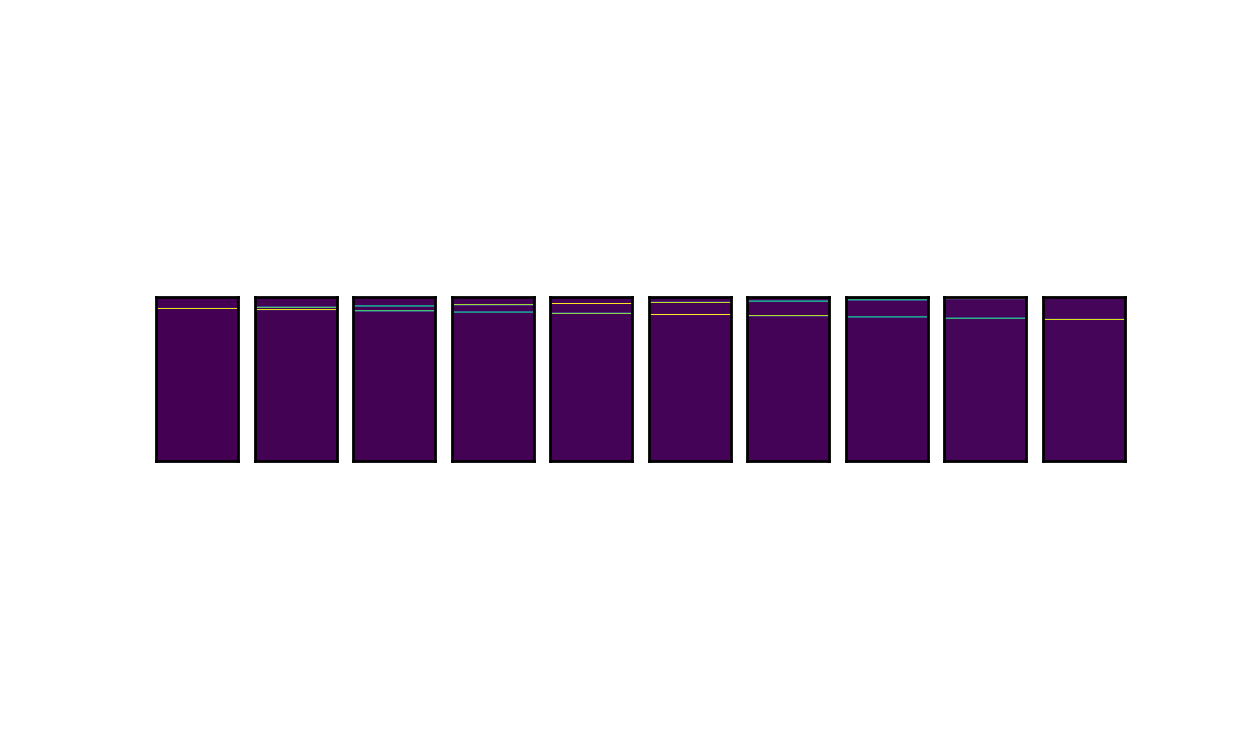

onedframes 3001


<IPython.core.display.Javascript object>


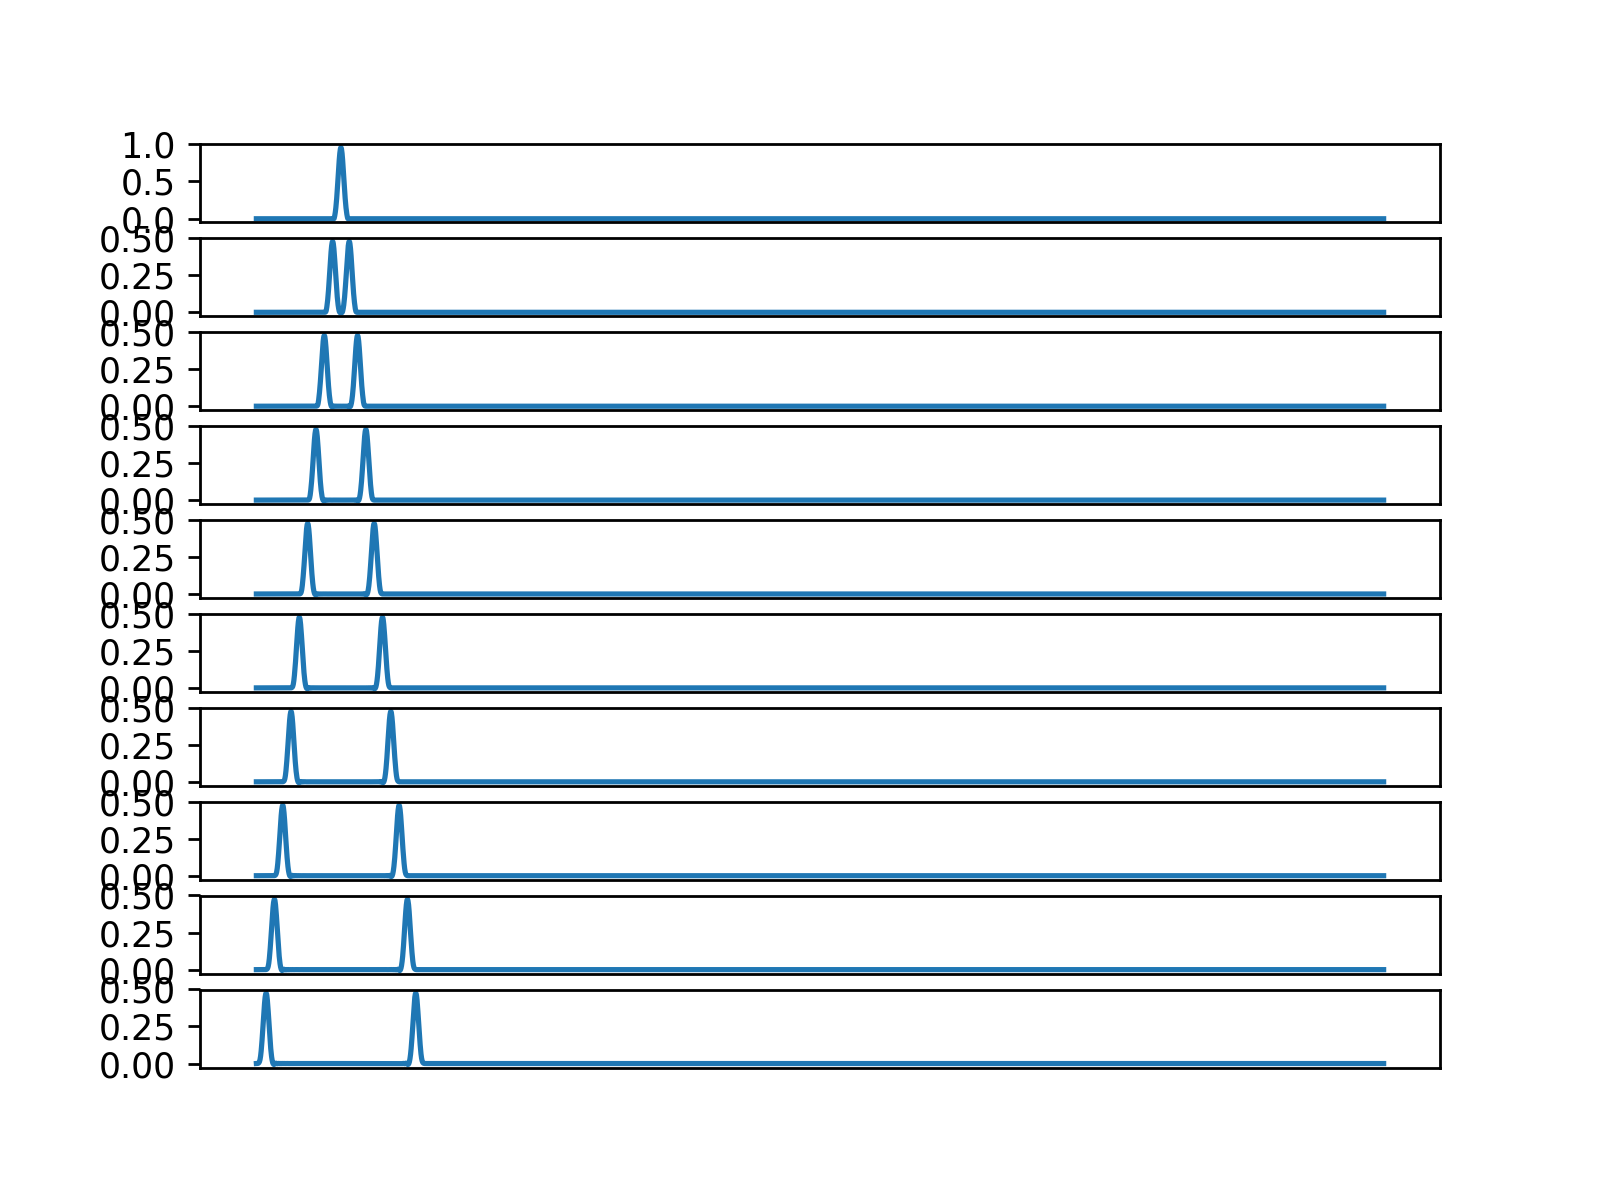

onedframes 3002


<IPython.core.display.Javascript object>


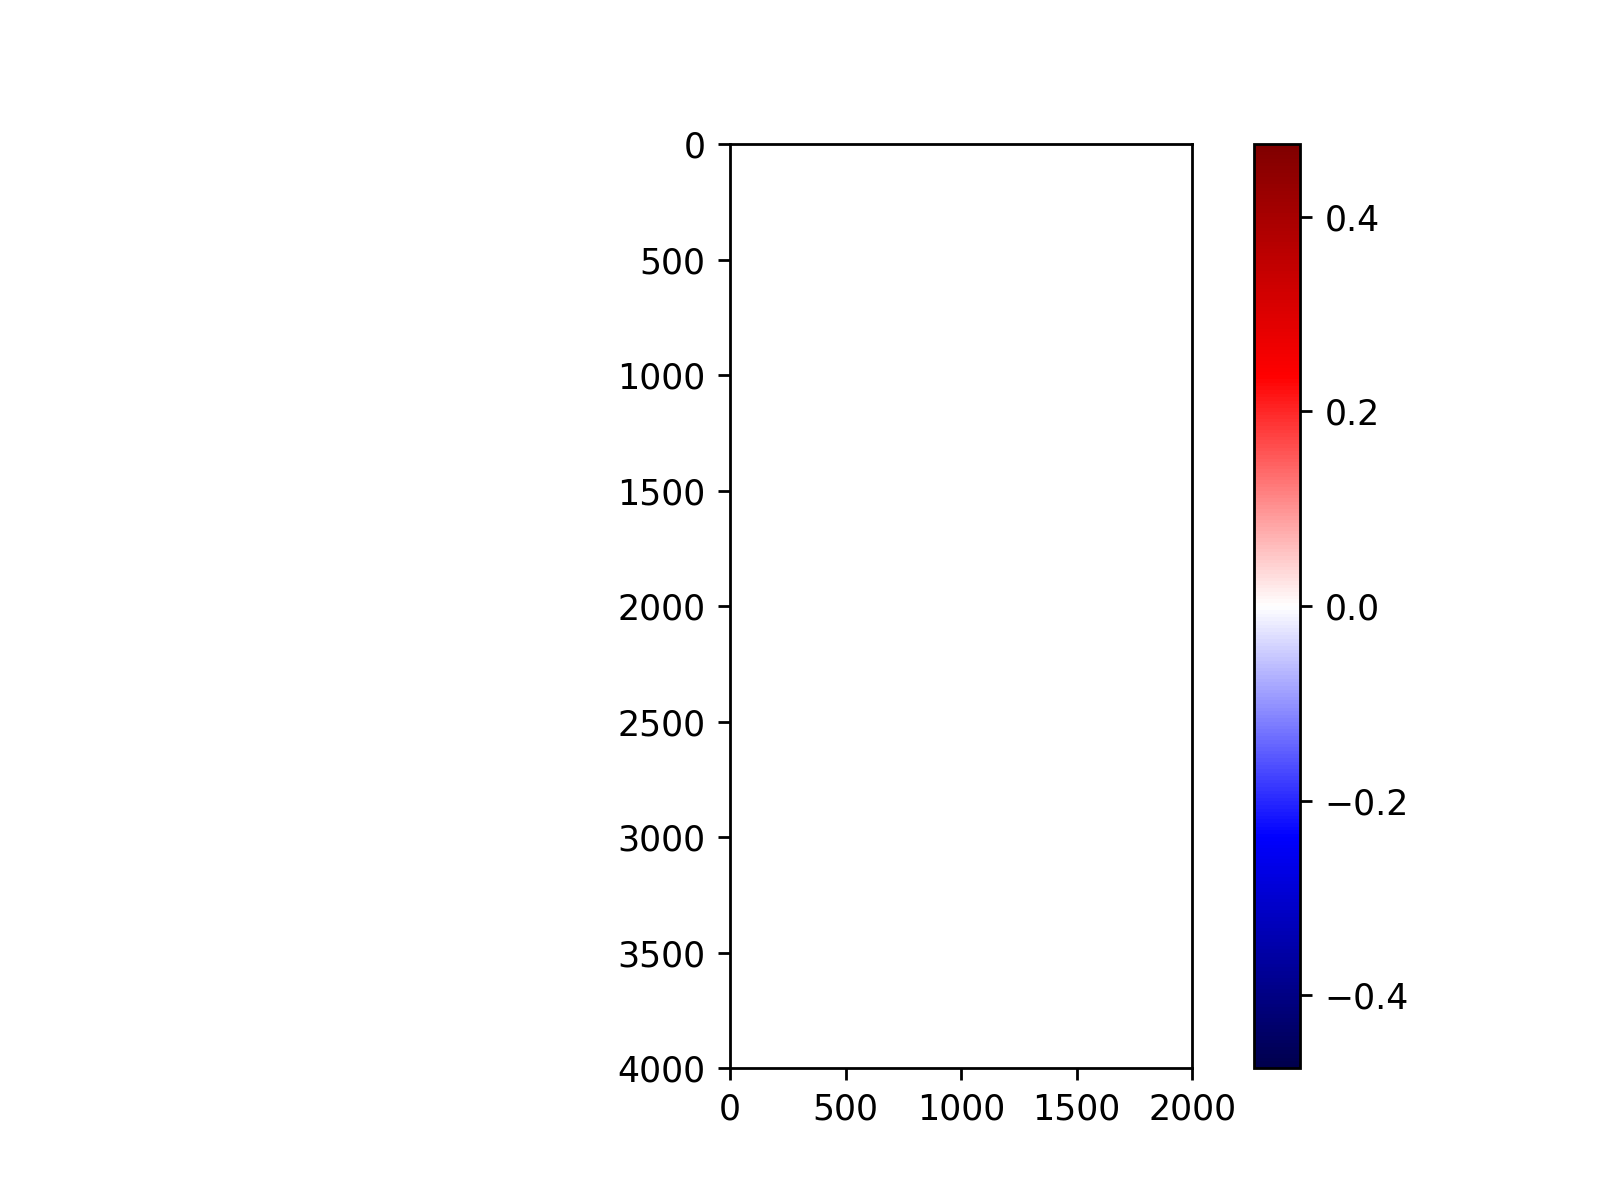

onedframes 3003
shape (37, 4000, 2000) 1000


<IPython.core.display.Javascript object>


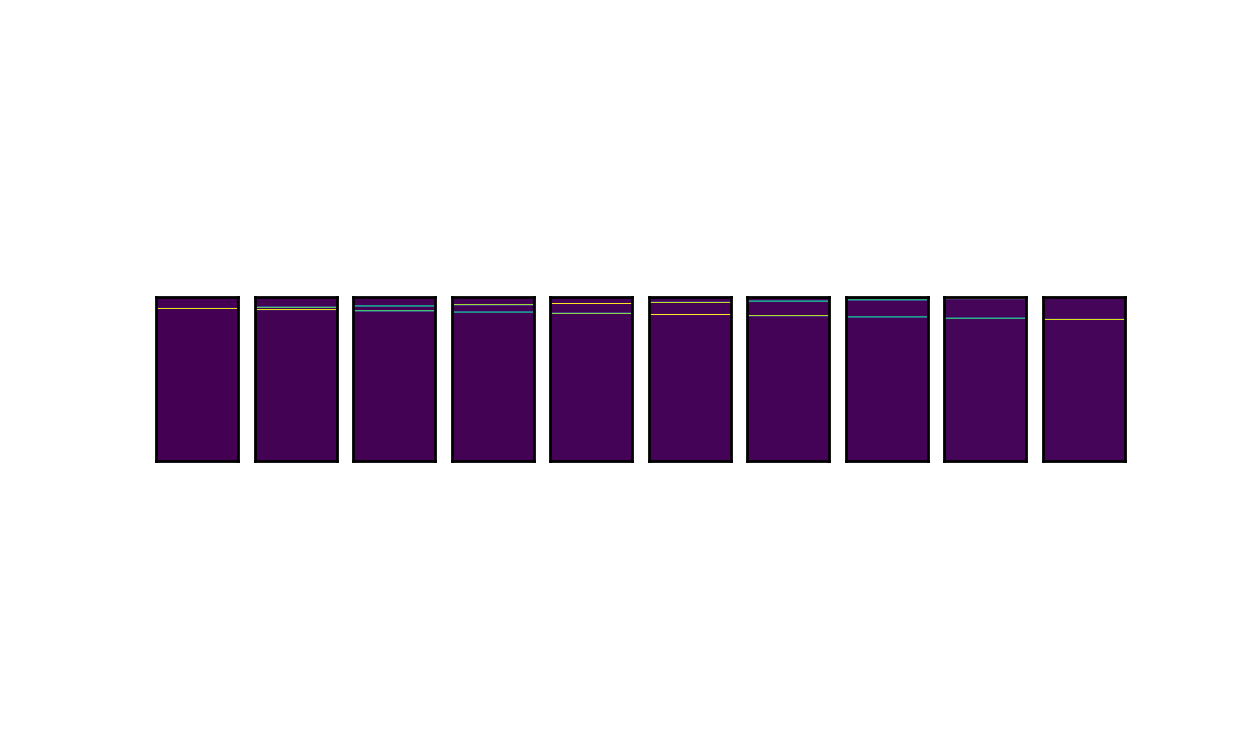

 conedframes 3004


<IPython.core.display.Javascript object>


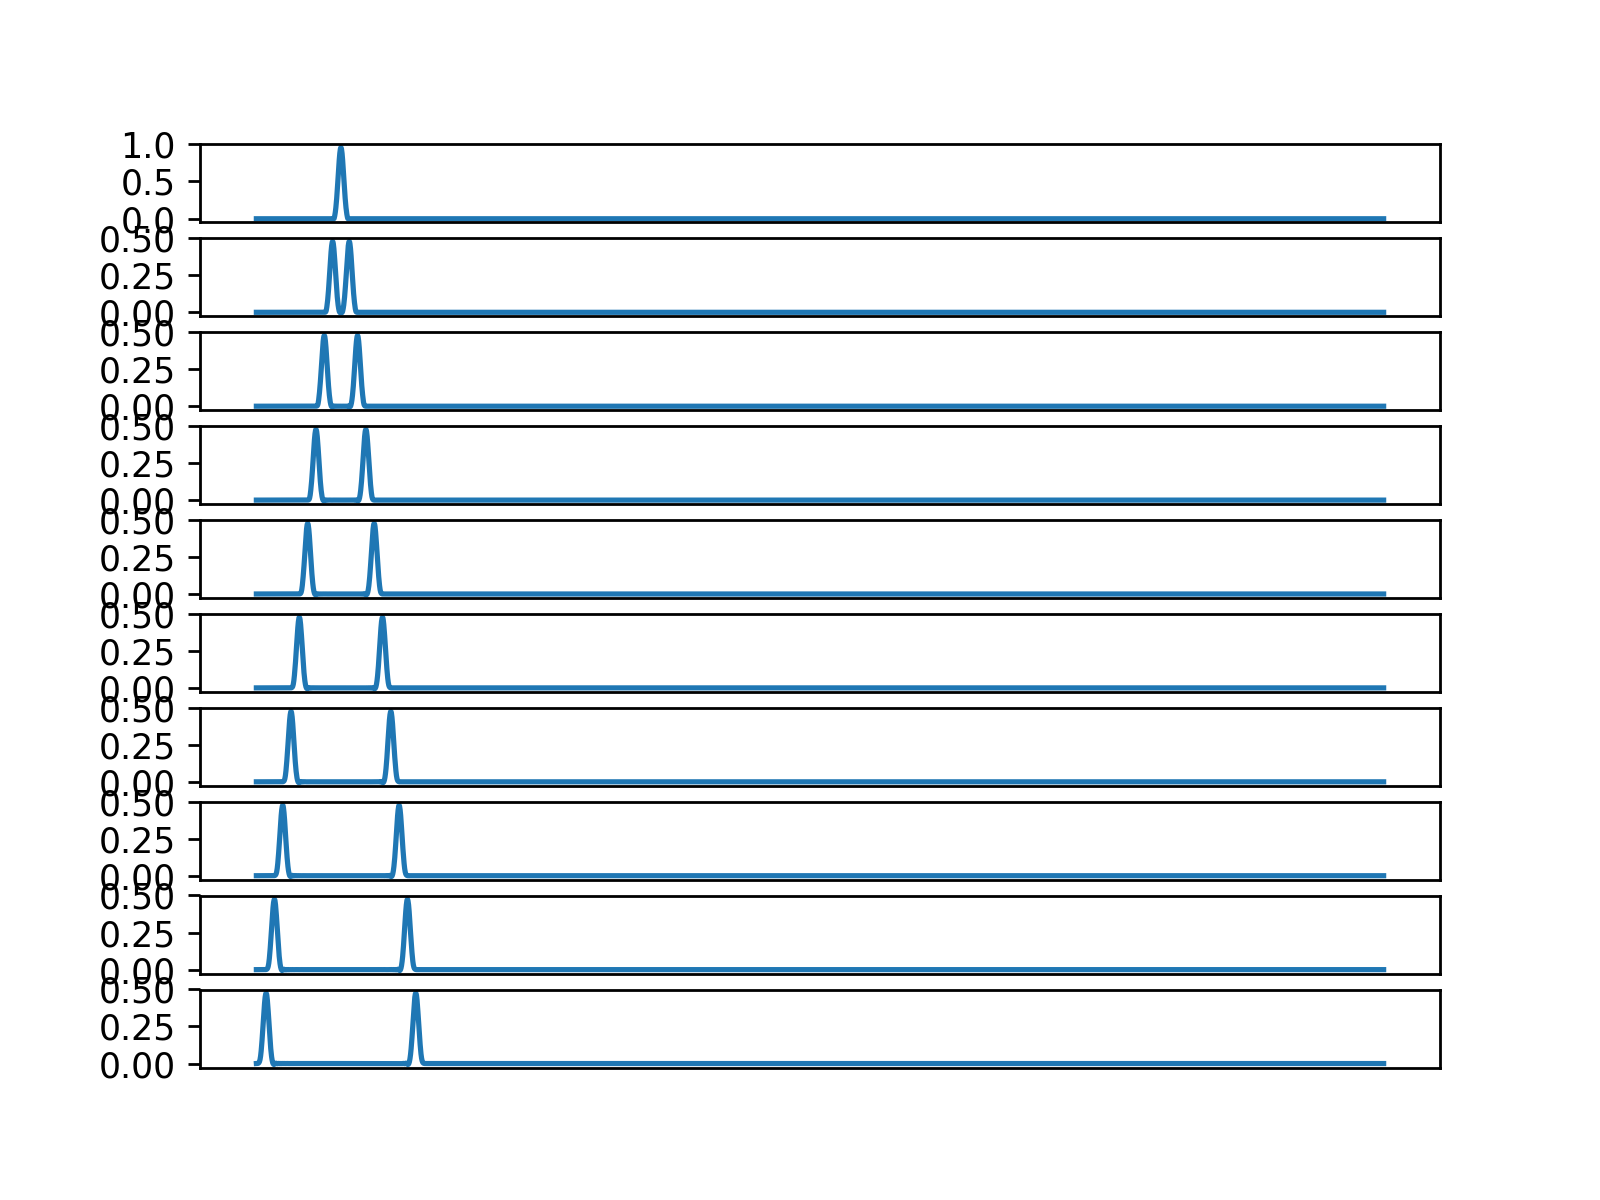

 conedframes 3005


<IPython.core.display.Javascript object>


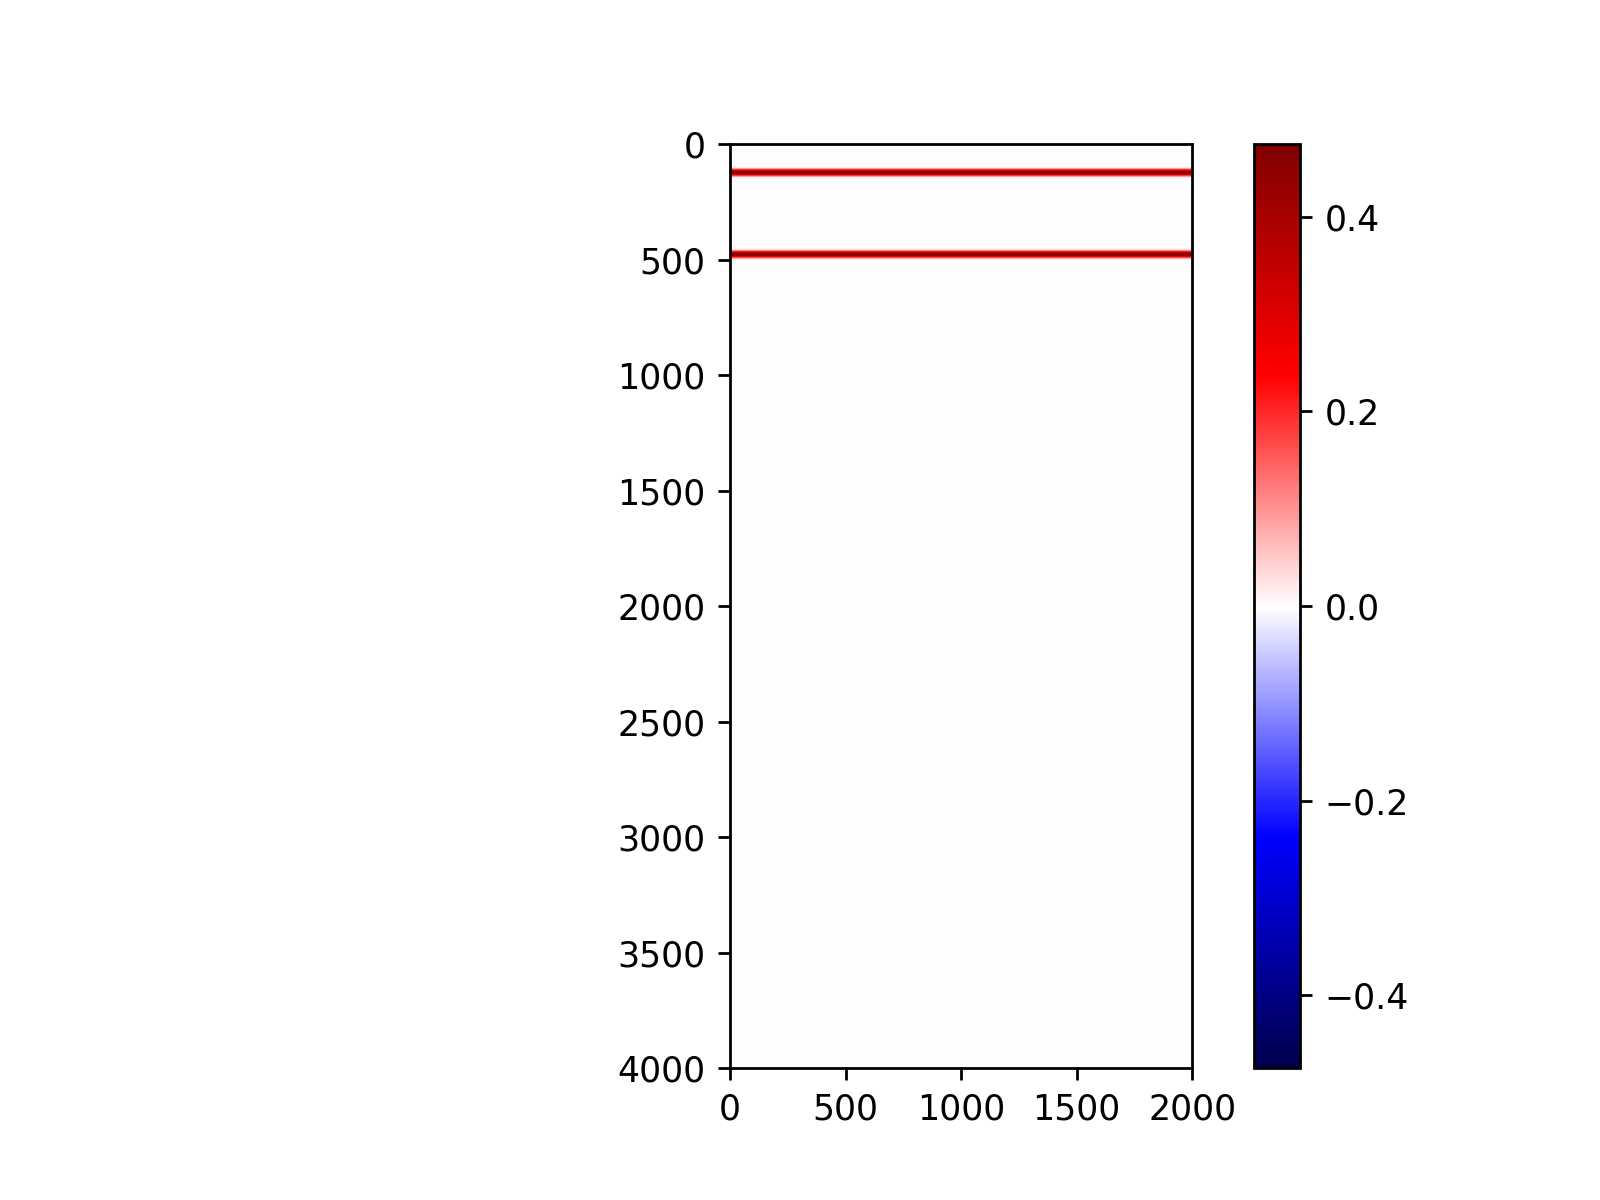

 conedframes 3006


In [59]:
# unit text compare numba and cuda
fnum = 3000
mmax = np.max(np.abs(onedframes))/2
print(mmax)
nplt=10
anims = []
for thing,name in zip((onedframes,  conedframes ),
                      "onedframes,  conedframes".split(', ')):
    mid = thing.shape[2]//2
    print("shape",thing.shape,mid)
    fnum +=1
    fig = plt.figure(fnum ,figsize=(5,3))
    plt.clf()
    plt.cla()
    #plt.title(name) 
    for i in range(nplt):
        f = i*1
        plt.subplot(1,nplt,i+1)
        plt.imshow(thing[f,:])
        plt.xticks([],[])
        plt.yticks([],[])
    #plt.tight_layout()   
    plt.show()
    print(name,fnum)

    fnum +=1
    fig = plt.figure(fnum)
    plt.clf()
    plt.title(name)
    for i in range(nplt):
        f = i*1
        plt.subplot(nplt,1,i+1)
        plt.plot(thing[f,:,mid])
        plt.xticks([],[])
        #plt.yticks([],[])
    #plt.tight_layout()
     
    plt.show()
    print(name,fnum)
    fnum +=1
    fig = plt.figure(fnum)
    plt.clf()
    onedart = [(plt.imshow(frame, vmin=-mmax, vmax=mmax, cmap='seismic'),)\
               for frame in thing]

    anims.append(animation.ArtistAnimation(fig, onedart, interval=200, \
                                     blit=True, repeat_delay=1000))
    plt.colorbar()
    # coast = plt.contour(oned['h'], levels=1, colors=['black'])
    # anim.save('../results/simpleplop.mp4')
    plt.show()
    print(name,fnum)





In [ ]:
a, b = np.mgrid[0:5,0:5]
# b = np.arange(10, 0, -1)
cudamax(a,b)
a,b

## unit test verification
assuming n (the sea surface height) is insignificant compared to h (the depth), then a solution to the shallow water equations can be approximated, giving the wave speed as the square root of the product of the gravity coeffecient and the depth. Using a unit test, the speed a wave propogates at in a small scale simulation is compared to this expected value. The unit tests verifies the wave speed is approximately correct within a reasonable margin of error, and thus verifies the model.

In [ ]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 100 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.float32(100) # meters
        self.dy = np.float32(100)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = np.float32(10000*np.ones(self.size))
        self.n = np.float32(0.1)*lingauss(self.size, 10, cy=500, theta=np.pi/2) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.dt = 0.3*self.dx/np.sqrt(np.max(self.h)*p.g)
        self.margin = 0.15 # error margin of test
        
        self.initialcondition = {
            'h':self.h,
            'n':self.n,
            'u':self.u,
            'v':self.v,
            'dt':self.dt,
            'dx':self.dx,
            'dy':self.dy,
            'lat':self.lat,
            'lon':self.lon
        }
#         self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(6)
        plt.clf()
#         plt.subplot(2, 1, 1)
#         plt.imshow(ar1)
#         plt.subplot(2, 1, 2)
#         plt.imshow(ar2)
        plt.plot(midstrip1)
        plt.plot(midstrip2, "--")
#         plt.plot(midstrip1-midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(9.81*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        
        self.simdata = simulate(self.initialcondition, self.dur, saveinterval=0.2, \
                                timestep=genfb, bounds=np.array([1, 1, 1, 1]), mu=0, cori=False, advx=False, advy=False, attn=False)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        fig = plt.figure(7)
        plt.imshow(self.simdata[0][:,5])#self.testStart.n)
#         arts = [(plt.imshow(frame),) for frame in self.simdata[0]]
#         anim = animation.ArtistAnimation(fig, arts)
        
        self.testFrames = self.simdata[0]
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.initialcondition['n'], self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(calcedws, exactws)
        print(err, self.margin)
        
        assert (abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

### small scale case as verification
running a small scale simulation of a initial disturbance like that from a rock thrown in a pond to verify the model

In [ ]:
oned2 = {
    'h': np.float32(1000*np.ones((sizex, sizey))),#(1-2*lingauss((sizex, sizey), 20, 20))),
    'n': np.float32(1*lingauss((sizex, sizey), 10, 500)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(50),
    'dy': np.float32(50),
    'dt': np.float32(0.2),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}
oned2['h'][:100] = -3
plt.figure()
plt.plot(-oned2['h'][:,25])
plt.plot(oned2['n'][:,25]*100)
plt.show()

In [ ]:
plt.figure()
plt.imshow(conedMax)
plt.colorbar()
plt.show()
plt.figure()
plt.clf()
onedart = [(plt.imshow(frame, vmin=-mmax, vmax=mmax, cmap='seismic'),) for frame in conedframes]

anim = animation.ArtistAnimation(fig, onedart, interval=20, blit=True, repeat_delay=200)
plt.colorbar()
# coast = plt.contour(oned['h'], levels=1, colors=['black'])
# anim.save('../results/simpleplop.mp4')
plt.show()


In [ ]:
tm = time.perf_counter()
onedframes2, onedMax2 = simulate(oned, 550, timestep=fbfeedback, saveinterval=20,\
                               dudt_x = dudt, dvdt_x = dvdt, dndt_x = dndt, \
                               bounds=[1, 1, 1, 1], \
                               grav=True, cori=True, advx=True, advy=True, attn=True)[:2]
print (time.perf_counter()-tm)
print (onedframes2.shape)

In [ ]:
np.array?

In [ ]:
sizex, sizey = 200, 200
pondrock = {
    'h': np.float32(1000*(1-2*lingauss((sizex, sizey), 20, -50, theta=3*np.pi/4))),
    'n': np.float32(1*seismic((sizex, sizey), 10, 10, 130, 70, theta=-1, a1=2, a2=0)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(100),
    'dy': np.float32(100),
    'dt': np.float32(0.3),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}

# simpleState = State(**simpletestcase)
# print(simpleState.dx, simpleState.dy, simpleState.h+simpleState.n)

In [ ]:
pondframes, pondMax = simulate(pondrock, 320, timestep=fbfeedback, saveinterval=2,\
                                           dudt_x = dudt_drive_numba, dvdt_x = dvdt_drive_numba, dndt_x = dndt_drive_numba, \
                                           bounds=[0.97, 0.97, 0.97, 0.97])[:2]

In [ ]:
fig = plt.figure(25)
mmax = np.max(np.abs(pondframes))/2
coast = plt.contour(pondrock['h'], levels=1, colors=['black'])
pondart = [(plt.imshow(frame, vmin=-mmax, vmax=mmax, cmap='seismic'),) for frame in pondframes]

anim = animation.ArtistAnimation(fig, pondart, interval=100, blit=True, repeat_delay=200)
plt.colorbar()
# anim.save('../results/simpleplop.mp4')
plt.show()
fig = plt.figure(27)
plt.imshow(pondMax)

# Simulating multiple tsunamis around Palu

### setting up conditions for all the Palu Simulations

In [ ]:
palu = {}
latran = (-1.2, 0.2) # latitude range map covers
lonran = (118.7, 121) # longitude range map covers

# calculate height of map  11100*lat degrees = meters
# calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
# use lon degree size of average latitude
realsize = (111000*(latran[1]-latran[0]),\
               111000*(lonran[1]-lonran[0])\
                  *np.cos((latran[1]-latran[0])/2))# h, w of map in meters
    
size = (700, 1150)# grid size of the map lat, lon


palu['dx'] = np.float32(realsize[1]/size[1])
palu['dy'] = np.float32(realsize[0]/size[0])
print('dx and dy ', palu['dx'], palu['dy'])

# read in bathymetry data
bathdata = nc.Dataset('../data/bathymetry.nc','r')
bathlat = bathdata.variables['lat']
bathlon = bathdata.variables['lon']
#calculate indexes of bathymetry dataset we need
bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                        np.argmin(np.abs(bathlat[:]-latran[1])),\
                        size[0], dtype=int)
bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                        np.argmin(np.abs(bathlon[:]-lonran[1])),\
                        size[1], dtype=int)
# print(bathlatix, bathlonix)
palu['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix], dtype=np.float32)
palu['lat'] = np.asarray(bathlat[bathlatix])
palu['lon'] = np.asarray(bathlon[bathlonix])

palu['n'] = np.zeros(size, dtype=np.float32)
palu['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
palu['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)

palu['dt'] = np.float32(0.3)*palu['dx']/np.sqrt(np.max(palu['h']*p.g))
# paluState = State(**palu)

### display coastline to verify correct setup of Palu

In [ ]:

fig = plt.figure(166)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))

### create array of multiple initial conditions of sea surface heights

In [ ]:

dist = 33000 # m from mouth of palu bay
center = (-0.63, 119.75) # point events are equidistant from
startang = np.pi/4 # angle of first event
endang = np.pi+0.01 # angle of last event
dang = np.pi/16 # change in angle

argcenter = (np.argmin(np.abs(palu['lat']-center[0])), \
             np.argmin(np.abs(palu['lon']-center[1]))) # the index of the center point
argdist = int(dist/palu['dx'])

print(argdist, argcenter)


seiswidth = int(5000/palu['dx'])
seislength = int(10000/palu['dy'])

    

initns = np.array([seismic(palu['n'].shape, \
                              width = seiswidth, \
                              length = seislength, \
                              a1 = 4, a2 = 1, \
                              cx = argcenter[0]-np.cos(ang)*argdist, \
                              cy = argcenter[1]-np.sin(ang)*argdist, \
                              theta = ang+np.pi) \
                      for ang in np.arange(startang, endang, dang)]) # array of the lat, lon positions of each event

### display the initial conditions

In [ ]:

spnum = 1
spcount = initns.shape[0]
plt.figure(176)
mmax = np.max(np.abs(initns))
for initn in initns:
    plt.subplot(int(np.int(np.sqrt(spcount)))+1, spcount/int(np.int(np.sqrt(spcount))), spnum)
    
    # sea surface height
    plt.imshow(initn[::-1], cmap='seismic', vmax=mmax, vmin=-mmax)
    
    # coast
    coast = plt.contour(palu['h'][::-1], levels=1, colors='black')
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    plt.xticks([], [])
    plt.yticks([], [])
    
    spnum += 1
plt.tight_layout()

## simulate each event and save the maximum heights from each one

In [ ]:
# paluState = State(**palu)

eventcount = initns.shape[0]

maxes = np.zeros((eventcount,) + palu['n'].shape)#np.array([])
# mins = np.zeros((eventcount,) + palu['n']shape)#np.array([])
# nttmm = np.array([])

evnum = 0 # keep track of which event number were on

for initn in initns:
    initd = dict(palu) # create copy of Palu init conditons
    initd['n'] = initn # with the initial SSH of this specific event
#     initstate = State(**initd) # turn into instance of State class
    
    maxn = simulate(initd, 2500, timestep=genfb, \
                    dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
                    grav=True, cori=True, advx=True, advy=True, attn=True)[1] # simulate it
    
    print('finished event ' + str(evnum)) # show progress
    
    maxes[evnum] = maxn # record data for this event
#     mins[evnum] = minn
#     maxes[evnum] = maxn
    
    evnum += 1
print('all done')
# save results
np.save('../results/palumaxheights', maxes)

In [ ]:
# or load previous results
# maxes = np.load('../results/palumaxheights.npy')

### display outcomes of each event

In [ ]:

stfignum = 117 # the neighborhood of figure numbers in use

# fignum = 0 # specific figure

#window including just palu bay
pb1 = 150
pb2 = 280
pb3 = 520
pb4 = 600

mmax = np.max(maxes[:,pb1:pb2,pb3:pb4]) # true max of maxes
imax = np.max(initns) # true max of initial SSH's

for fignum, initn in enumerate(initns): # display initial SSH of each event
    fig = plt.figure(stfignum+fignum) # start new figures
    
#     plt.subplot(1, 2, 1)
    plt.imshow(initn[::-1], cmap='seismic', vmax = imax, vmin=-imax)# plot initial condition
    plt.colorbar()
    coast = plt.contour(palu['h'][::-1]-1.5, levels=1, colors='black') # plot coast
    
    # use latitude, longitude tick markers
    xtixks = plt.xticks(np.linspace(0, palu['h'][::-1].shape[1], 5),\
               np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, palu['h'][::-1].shape[0], 5),\
               np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
#     plt.xticks([], [])
#     plt.yticks([], [])
    
    plt.savefig('../results/palu-init-' + str(fignum)) # download image
    
#     fignum+=1 # next figure
 # repeat of last with colorbar
# plt.figure(stfignum+13)
# plt.imshow(initns[-1], cmap='seismic', vmax=imax, vmin=-imax)
# plt.colorbar()
# plt.savefig('../results/palu-init-cb')
# fignum+=1
for fignum, maxn in enumerate(maxes): # display maximum heights in palu bay of each event
    fig = plt.figure(stfignum+fignum+14) # start new figure
    
#     plt.subplot(1, 2, 2)
    plt.imshow(maxn[pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0) # show max height image
    plt.colorbar()
    coast = plt.contour(palu['h'][pb2:pb1:-1, pb3:pb4]-1.5, levels=1, colors='black') # the coast
    
    # use latitude, longitude tickmarks
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.savefig('../results/palu-max-' + str(fignum)) # download image
    
#     fignum += 1 # next figure
# repeat of last event, but with colorbar
# plt.figure(stfignum+27)
# plt.imshow(maxes[-1][pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0)
# plt.colorbar()
# plt.savefig('../results/palu-max-cb')plt.colorbar()